In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Plots for comparing Actual and Predicted Statistics on Generation

In [2]:
canon_canon = '/nfs/c9/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/general_statistics/selfies/canon_canon.xlsx'
canon_rand= '/nfs/c9/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/general_statistics/selfies/canon_rand.xlsx'
rand_canon = '/nfs/c9/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/general_statistics/selfies/rand_canon.xlsx'
rand_rand = '/nfs/c9/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/general_statistics/selfies/rand_rand.xlsx'

rand_rand_data = pd.read_excel(rand_rand)
rand_canon_data = pd.read_excel(rand_canon)
canon_rand_data = pd.read_excel(canon_rand)
canon_canon_data = pd.read_excel(canon_canon)


In [3]:
categories = ['Unique TP', 'Duplicated TP', 'Out of Distribution']
subset_names = ['Aspirin', 'Sas', 'Druglike', 'Equal Distance']
num_gen = 1_000_000

def get_actual_results(data):
    results = {'Aspirin': [], 'Sas': [], 'Druglike': [], 'Equal Distance': []}
    for idx, subset in enumerate(subset_names):
        dup_tp = data['Actual Duplicated TP'][idx]
        uniq_tp = data['Actual Unique TP'][idx]
        diff_dup_uniq = dup_tp - uniq_tp
        out_of_dist = num_gen - dup_tp
        results[subset].extend([uniq_tp, diff_dup_uniq, out_of_dist])

    return results

def get_predicted_results(data):
    results = {'Aspirin': [], 'Sas': [], 'Druglike': [], 'Equal Distance': []}
    for idx, subset in enumerate(subset_names):
        dup_tp = data['Predicted Duplicated TP'][idx]
        uniq_tp = data['Predicted Unique TP'][idx]
        diff_dup_uniq = dup_tp - uniq_tp
        out_of_dist = num_gen - dup_tp
        results[subset].extend([uniq_tp, diff_dup_uniq, out_of_dist])

    return results

results_rand_rand = get_actual_results(rand_rand_data)
results_rand_canon = get_actual_results(rand_canon_data)
results_canon_rand = get_actual_results(canon_rand_data)
results_canon_canon = get_actual_results(canon_canon_data)

results_rand_rand_pred = get_predicted_results(rand_rand_data)
results_rand_canon_pred = get_predicted_results(rand_canon_data)
results_canon_rand_pred = get_predicted_results(canon_rand_data)
results_canon_canon_pred = get_predicted_results(canon_canon_data)

In [4]:
def plot_gen_stats(results, results_pred, save):
    actuals = results
    preds = results_pred

    first_row = []
    second_row = []
    third_row = []

    pred_first_row = []
    pred_second_row = []
    pred_third_row = []

    for i in actuals:
        first_row.append(actuals[i][0])     
        second_row.append(actuals[i][1])
        third_row.append(actuals[i][2])

    for i in preds:
        pred_first_row.append(preds[i][0])     
        pred_second_row.append(preds[i][1])
        pred_third_row.append(preds[i][2])
    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot(1, 1, 1)

    names = ['$S_{asp}$', '$S_{sas}$', '$S_{d>p}$', '$S_{d=p}$']
    ind = np.arange(4)

    plt.xticks([250000,500000,750000,1000000])
    ax.set_xticklabels(['250,000', '500,000', '750,000', '1,000,000'])
    ax.yaxis.set_visible(False)

    height = 0.3
    out = height

    # Horizontal bars for actual data
    for i, (f, s, t) in enumerate(zip(first_row, second_row, third_row)):
        ax.barh(ind[i], f, height=height, color='#32874A', edgecolor='black', linewidth=1)
        ax.barh(ind[i], s, left=f, height=height, color='#ffdd77', edgecolor='black', linewidth=1)
        ax.barh(ind[i], t, left=np.array(f) + np.array(s), height=height, color=(0.89888504, 0.30549789, 0.20676663, 1. ), edgecolor='black', linewidth=1)

    # Horizontal bars for predicted data
    for i, (f, s, t) in enumerate(zip(pred_first_row, pred_second_row, pred_third_row)):
        ax.barh(ind[i] + out, f, height=height, color=(0.24805844, 0.66720492, 0.3502499 , 0.4 ), edgecolor='black', linewidth=1)
        ax.barh(ind[i] + out, s, left=f, height=height, color=(0.99707805, 0.9987697 , 0.74502115, 0.5), edgecolor='black', linewidth=1)
        ax.barh(ind[i] + out, t, left=np.array(f) + np.array(s), height=height, color=(0.89888504, 0.30549789, 0.20676663, 0.4 ), edgecolor='black', linewidth=1)

    # Add labels indicating actual and predicted data
    for i, subset in enumerate(names):
        # ax.text(50000, ind[i], 'Generated', ha='center', va='center')
        # ax.text(-50000, ind[i]+ out, 'Predicted', ha='center', va='center')
        ax.text(1100000, ind[i], subset, ha='center', va='center')

    # Add custom legend
    legend_handles_1 = [mpatches.Patch(color='#32874A'), mpatches.Patch(color='#ffdd77'), mpatches.Patch(color=(0.89888504, 0.30549789, 0.20676663, 1. ))]
    ax.legend(handles=legend_handles_1, labels=['In Subset Molecules', 'Duplicates', 'Out of Subset Molecules'], loc='lower right',bbox_to_anchor=(1, 1.1), edgecolor='black')

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0, 1, 1])

    plt.savefig(save)
    # plt.title(f'Pre-Train: {pretrain}, Fine-Tune: {finetune}')
    plt.show()

### Alternatve Graphics

In [5]:
def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(True)
    ax.set_xlim(0, np.sum(data, axis=1).max())
    
    ax.set_xticks([250000, 500000, 750_000, 1000000])
    labels = ['250,000', '500,000', '750,000', '1,000,000']
    ax.set_xticklabels(labels)

    ax.set_yticks(np.arange(len(results.keys())))
    ax.set_yticklabels(results.keys())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        # r, g, b, _ = color
        # text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        # ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncols=1, bbox_to_anchor=(1.24,1.1),
              loc='upper right', fontsize='small')

    return fig, ax

## Aspirin 1M temperature generation plots

In [6]:
def plot_temp_scatter(df,save_path,metric_type):
    metric = list(df[metric_type])
    temperature = list(df['Temp'])

    plt.figure(figsize=(10, 6))

    if metric_type == 'Recall':
        color = '#2ca02c'
        plt.axhline(y=11.37, color='#8B0000', linewidth=2,label='Upper Bound (i.i.d.)')
        
    elif metric_type == 'Precision':
        color = '#ffbf00'
    # Plot the data with different styles and colors
    # plt.plot(temp, precision, marker='o', linestyle='-', color='#ffbf00', label='Precision (%)')
    plt.plot(temperature, metric, marker='s', linestyle='--', color=color, label=f'{metric_type} (%)')
    
    # plot a black horizontal line at y=11.37
    # Use a logarithmic scale if needed
    # plt.yscale('log')

    # Add labels and title with a subtitle
    plt.xlabel('Temperature', fontsize=14, labelpad=12)
    # plt.title(f'Pre-Training: {pretrain}, Fine-Tuning: {finetune}', fontsize=14)

    # Customize grid and background
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.gca().set_facecolor('white')

    # Position the legend outside the plot
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

    plt.tick_params(axis='both', which='major', labelsize=12)
    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0, 1, 1])

    # plt.savefig(save_path, format="pdf")
    # Show the plot
    plt.show()

In [7]:
subset = 'aspirin'
path = '/nfs/c9/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/actual_generation_statistics/selfies/aspirin'
temps = [0.9, 0.8, 1.1, 1.3, 1.5, 1.7, 1.8, 0.7, 0.6, 0.95,1]
canon_canon = [os.path.join(path,f'PRETRAIN_canon_FINETUNE_canon_FROM_GEN_1M_GEN_LEN_1M_TEMP_{tmp}.xlsx') for tmp in temps]
canon_rand = [os.path.join(path,f'PRETRAIN_canon_FINETUNE_rand_FROM_GEN_1M_GEN_LEN_1M_TEMP_{tmp}.xlsx') for tmp in temps]

In [8]:
canon_canon_df = pd.DataFrame()
canon_rand_df = pd.DataFrame()

for file in canon_canon:
    canon_canon_df = pd.concat([canon_canon_df,pd.read_excel(file)])
canon_canon_df['Temp'] = temps
canon_canon_df = canon_canon_df.reset_index()
canon_canon_df = canon_canon_df.drop('index',axis=1)
canon_canon_df = canon_canon_df.sort_values(by='Temp')

for file in canon_rand:
    canon_rand_df = pd.concat([canon_rand_df,pd.read_excel(file)])
canon_rand_df['Temp'] = temps
canon_rand_df = canon_rand_df.reset_index()
canon_rand_df = canon_rand_df.drop('index',axis=1)
canon_rand_df = canon_rand_df.sort_values(by='Temp')

In [9]:
canon_canon_df['Generation'] = [1_000_000]*11
canon_canon_df['Precision'] = (canon_canon_df['Actual Duplicated TP']/canon_canon_df['Generation'])*100
canon_canon_df['Recall'] = (canon_canon_df['Actual Unique TP']/8284280)*100
canon_canon_df = canon_canon_df.drop(columns=['Actual Duplicated TP', 'Actual Unique TP', 'Generation'])

In [10]:
canon_rand_df['Generation'] = [1_000_000]*11
canon_rand_df['Precision'] = (canon_rand_df['Actual Duplicated TP']/canon_rand_df['Generation'])*100
canon_rand_df['Recall'] = (canon_rand_df['Actual Unique TP']/8284280)*100
canon_rand_df = canon_rand_df.drop(columns=['Actual Duplicated TP', 'Actual Unique TP', 'Generation'])

In [11]:
canon_canon_df

,Temp,Precision,Recall
8,0.60,88.5516,8.126138
7,0.70,86.0074,8.970375
1,0.80,83.0220,9.156909
0,0.90,79.4689,8.971389
9,0.95,77.7088,8.818376
10,1.00,75.6477,8.612432
2,1.10,71.5583,8.162013
3,1.30,62.1868,7.035856
4,1.50,52.2593,5.834726
5,1.70,42.2480,4.649082


In [12]:
canon_rand_df

,Temp,Precision,Recall
8,0.60,87.2450,8.067521
7,0.70,83.7404,8.804036
1,0.80,79.6855,8.845198
0,0.90,75.2901,8.543989
9,0.95,73.0170,8.336826
10,1.00,70.6235,8.095863
2,1.10,65.4555,7.526810
3,1.30,54.6335,6.292291
4,1.50,43.7410,5.028898
5,1.70,33.3758,3.836447


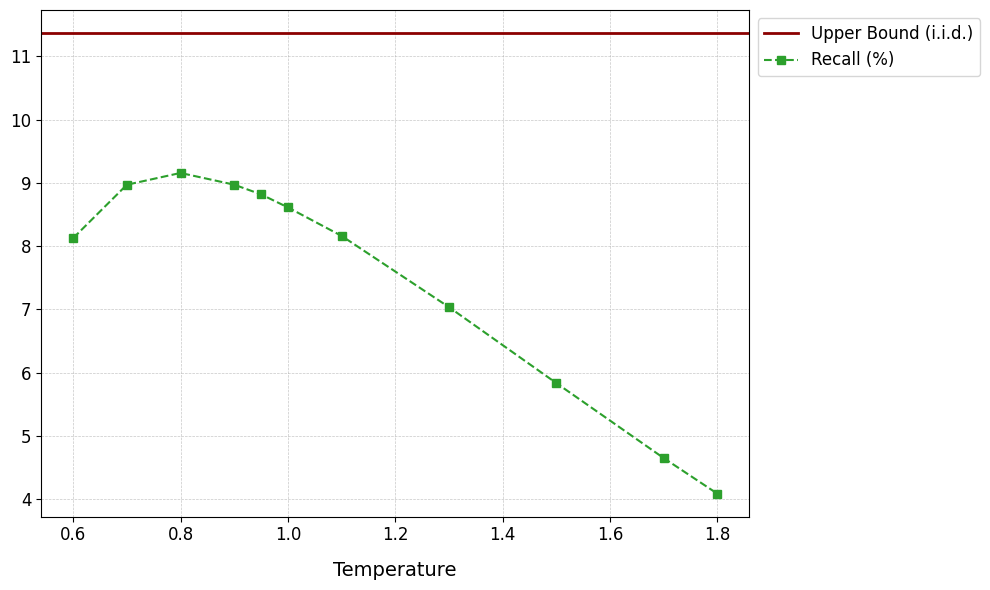

In [13]:
plot_temp_scatter(canon_canon_df, '/nfs/c9/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/plots/aspirin_temp_canon_canon_recall.pdf', 'Recall')

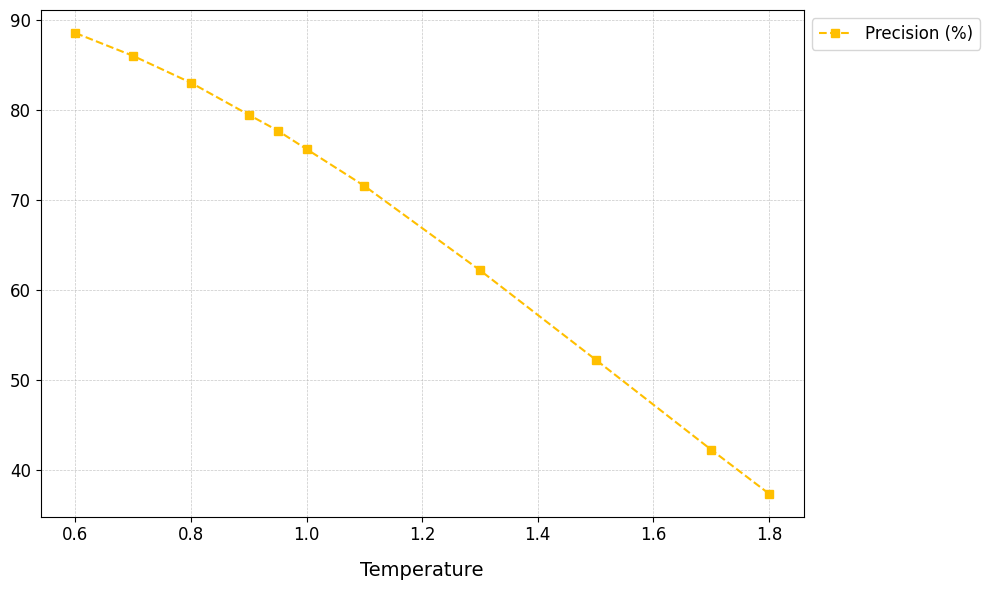

In [14]:
plot_temp_scatter(canon_canon_df, '/nfs/c9/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/plots/aspirin_temp_canon_canon_precision.pdf', 'Precision')

In [15]:
def metrics_pred_temp(results, save_path):
    # Data
    temp = results['Temp']
    precision = results['Precision']
    recall = results['Recall']

    # Create the figure and axis
    fig, ax1 = plt.subplots()

    # Plot recall on the left y-axis
    ax1.plot(temp, recall, '#5faf72', marker='o', label='Recall')
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Recall', color='#5faf72')
    ax1.tick_params('y', colors='#5faf72')

    # Create a second y-axis for precision
    ax2 = ax1.twinx()
    ax2.plot(temp, precision, '#e08c5c', marker='x', label='Precision')
    ax2.set_ylabel('Precision', color='#e08c5c')
    ax2.tick_params('y', colors='#e08c5c')

    # Add a title and grid
    # plt.title('Recall and Precision with temperature sampling.')
    ax1.grid(True)

    plt.savefig(save_path, format='pdf')
    # Show the plot
    plt.show()


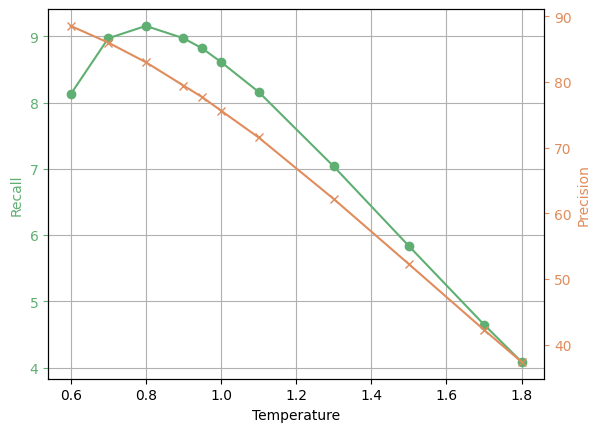

In [16]:
metrics_pred_temp(canon_canon_df, 'aspirin_temp_canon_canon_recall_green.pdf')

In [21]:
code_temp_df = pd.DataFrame()
code_temp_df["Temp"] =  [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.3, 1.5, 1.7, 1.8]
code_temp_df["Precision"] = [88.01, 85.06, 82.42, 79.72, 77.09, 74.58, 71.88, 66.58, 60.48, 52.34, 47.65]
code_temp_df["Recall"] = [10.53, 10.98, 11.08, 10.95, 10.72, 10.43, 10.09, 9.31, 8.36, 7.16, 6.5]
code_temp_df

,Temp,Precision,Recall
0,0.5,88.01,10.53
1,0.6,85.06,10.98
2,0.7,82.42,11.08
3,0.8,79.72,10.95
4,0.9,77.09,10.72
5,1.0,74.58,10.43
6,1.1,71.88,10.09
7,1.3,66.58,9.31
8,1.5,60.48,8.36
9,1.7,52.34,7.16


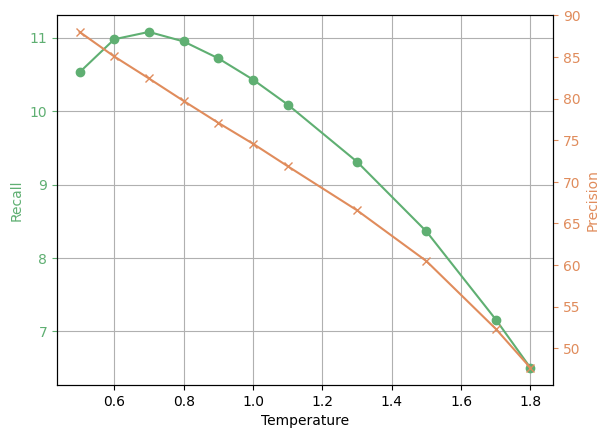

In [22]:
metrics_pred_temp(code_temp_df, 'code_temp.pdf')

In [17]:
# metrics_pred_temp(canon_rand_df, 'aspirin_temp_canon_rand_recall_final.pdf')

## 1K-10M Generations Plots

In [18]:
def plot_gens_scatter(df, subset_length,save):
    actual_dup_tp = list(df['Actual Duplicated TP'])
    actual_uniq_tp = list(df['Actual Unique TP'])

    gen = list(df['Gen Length'])

    recall = ((df['Actual Unique TP']/subset_length)*100).iloc[-1]
    # precision = ((df['Actual Duplicated TP']/df['Gen Length'])*100).iloc[-1]

    x = np.linspace(0, subset_length, 1000)
    y = x

    x_full = np.linspace(0, 1_000_000, 10000)
    upper_bound = subset_length * (1-(1-1/subset_length)**x_full)

    # Generate subset length line
    subset_length_line = np.array([subset_length] * 10000)

    plt.figure(figsize=(8.5, 4.5))

    # Plot the reference lines
    plt.plot(x, y, color='#6889bd', linestyle='--', label='Ideal Case')
    plt.plot(x_full, upper_bound, color='#5faf72', linestyle='--', label='Upper Bound (i.i.d.)')
    plt.plot(x_full, subset_length_line, color='black', linestyle='--', label='Size of the Set ($M$)')

    # Set y-axis limit
    plt.ylim(0, 1_000_000)

    # Annotate recall and diff percentages
    # plt.text(gen[-1], actual_dup_tp[-1], f'{round(precision, 2)}%', verticalalignment='bottom', horizontalalignment='right', fontsize=12, color='blue')
    plt.text(gen[-1], actual_uniq_tp[-1], f'{round(recall, 2)}%', fontsize=11, verticalalignment='bottom', horizontalalignment='center', color='green')

    # Plot actual data points
    plt.plot(gen, actual_dup_tp, marker='o', linestyle='-', color='#e08c5c', label='True Positives')
    plt.plot(gen, actual_uniq_tp, marker='o', linestyle='-', color='#5faf72', label='Unique True Positives')

    # Add labels and title
    plt.xlabel('Number of Generated Code Snippets', fontsize=14, labelpad=12)
    # plt.ylabel('True Positives', fontsize=12)
    # plt.title(f'Pre-Training: {pretrain}, Fine-Tuning: {finetune}', fontsize=12)

    # Customize grid and background
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.gca().set_facecolor('white')

    # Position the legend outside the plot
    plt.legend(loc='upper left', bbox_to_anchor=(0.0, 0.98), fontsize=12, edgecolor='#EAEAEB')
    plt.tick_params(axis='both', which='major', labelsize=12)
    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0, 1, 1])

    plt.savefig(save, format='pdf')
    # Show the plot
    plt.show()

# Example usage:
# plot_gens_scatter(subset, df, pretrain, finetune, subset_length, recall, diff)


In [19]:
gen_lengths = [1_000, 10_000, 100_000, '1M', 2_000_000, 6_000_000, 8_000_000, '10M']

### General Stats

In [20]:
subsets = ['aspirin', 'sas', 'druglike', 'eqdist']
pretrain = ['canon','rand']
finetune = ['canon','rand']

for p in pretrain:
    for f in finetune:
        statistics = {'Subset':[], 'Actual Duplicated TP':[], 'Actual Unique TP':[]}
        for subset in subsets:
            df = pd.read_excel(f'/nfs/c9/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/actual_generation_statistics/selfies/{subset}/PRETRAIN_{p}_FINETUNE_{f}_FROM_GEN_10M_GEN_LEN_10M_TEMP_1.xlsx')
            dup = df['Actual Duplicated TP'][0]
            uniq = df['Actual Unique TP'][0]
            statistics['Subset'].append(subset)
            statistics['Actual Duplicated TP'].append(dup)
            statistics['Actual Unique TP'].append(uniq)
        stats_df =pd.DataFrame(statistics)
        PATH = f'/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/general_statistics/{p}_{f}_10M.xlsx'
        # stats_df.to_excel(PATH, index=False)

In [21]:
canon_canon = pd.read_excel('/nfs/c9/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/general_statistics/selfies/canon_canon_10M_original.xlsx')
canon_rand = pd.read_excel('/nfs/c9/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/general_statistics/selfies/canon_rand_10M_original.xlsx')
rand_canon = pd.read_excel('/nfs/c9/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/general_statistics/selfies/rand_canon_10M_original.xlsx')
rand_rand = pd.read_excel('/nfs/c9/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/general_statistics/selfies/rand_rand_10M_original.xlsx')

In [22]:
tables = [canon_canon, canon_rand, rand_canon, rand_rand]

In [23]:
subset_len = {'aspirin': 8284280,
'sas' : 6645440,
'druglike' : 9331077,
'eqdist' : 8051185 }
subset_length = [8284280, 6645440, 9331077, 8051185]

In [24]:
for t in tables:
    t['Subset Length'] = subset_length

In [25]:
for df in tables:
    df['Recall'] = (df['Actual Unique TP']/df['Subset Length'])*100

In [26]:
for df in tables:
    diff = df['Actual Duplicated TP'] - df['Actual Unique TP']
    df['Diff'] = (diff/df['Actual Duplicated TP'])*100

In [27]:
canon_canon

,Subset,Actual Duplicated TP,Predicted Duplicated TP,Diff Duplicated TP,Actual Unique TP,Predicted Unique TP,Diff Unique TP,Validation Length,Sum Probs,Subset Length,Recall,Diff
0,aspirin,7569055,7399390,169665,4558240,4486343,71897,10000,0.000893,8284280,55.022766,39.777951
1,sas,8058081,7991131,66950,4303269,4279902,23367,10000,0.001202,6645440,64.755216,46.596851
2,druglike,6827435,6653951,173484,4369476,4293835,75641,10000,0.000713,9331077,46.827135,36.001207
3,eqdist,1407172,1350754,56418,1222933,1178540,44393,10000,0.000168,8051185,15.189478,13.092856


In [28]:
canon_rand

,Subset,Actual Duplicated TP,Predicted Duplicated TP,Diff Duplicated TP,Actual Unique TP,Predicted Unique TP,Diff Unique TP,Validation Length,Sum Probs,Subset Length,Recall,Diff
0,aspirin,7059369,7017213,42156,4452203,4433416,18787,10000,0.000847,8284280,53.742788,36.931998
1,sas,7326080,7338257,12177,4134374,4143258,8884,10000,0.001104,6645440,62.213698,43.566355
2,druglike,6163090,6094771,68319,4189576,4152256,37320,10000,0.000653,9331077,44.899169,32.021502
3,eqdist,1086664,1079342,7322,997388,991570,5818,10000,0.000134,8051185,12.388089,8.215603


In [29]:
rand_canon

,Subset,Actual Duplicated TP,Predicted Duplicated TP,Diff Duplicated TP,Actual Unique TP,Predicted Unique TP,Diff Unique TP,Validation Length,Sum Probs,Subset Length,Recall,Diff
0,aspirin,7616563,7455878,160685,4540085,4468146,71939,10000,0.000900,8284280,54.803616,40.391946
1,sas,8026134,7977750,48384,4265002,4245006,19996,10000,0.001200,6645440,64.179377,46.861067
2,druglike,6893833,6782528,111305,4363563,4316162,47401,10000,0.000727,9331077,46.763766,36.703384
3,eqdist,1458330,1411841,46489,1261295,1223884,37411,10000,0.000175,8051185,15.665955,13.511002


In [30]:
rand_rand

,Subset,Actual Duplicated TP,Predicted Duplicated TP,Diff Duplicated TP,Actual Unique TP,Predicted Unique TP,Diff Unique TP,Validation Length,Sum Probs,Subset Length,Recall,Diff
0,aspirin,7515469,7482479,32990,4672525,4659205,13320,10000,0.000903,8284280,56.402307,37.827899
1,sas,7617117,7638271,21154,4258098,4269162,11064,10000,0.001149,6645440,64.075486,44.098299
2,druglike,6566746,6518009,48737,4430389,4404024,26365,10000,0.000699,9331077,47.479932,32.532962
3,eqdist,1367136,1367181,45,1233863,1233968,105,10000,0.000170,8051185,15.325235,9.748335


### Aspirin

In [31]:
subset = 'aspirin'
pretrain = 'canon'
finetune = 'canon'

aspirin_canon_canon = [f'/nfs/c9/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/actual_generation_statistics/selfies/{subset}/PRETRAIN_{pretrain}_FINETUNE_{finetune}_FROM_GEN_10M_GEN_LEN_{gen_len}_TEMP_1.xlsx' for gen_len in gen_lengths]

In [32]:
aspirin_canon_canon

['/nfs/c9/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/actual_generation_statistics/selfies/aspirin/PRETRAIN_canon_FINETUNE_canon_FROM_GEN_10M_GEN_LEN_1000_TEMP_1.xlsx',
 '/nfs/c9/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/actual_generation_statistics/selfies/aspirin/PRETRAIN_canon_FINETUNE_canon_FROM_GEN_10M_GEN_LEN_10000_TEMP_1.xlsx',
 '/nfs/c9/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/actual_generation_statistics/selfies/aspirin/PRETRAIN_canon_FINETUNE_canon_FROM_GEN_10M_GEN_LEN_100000_TEMP_1.xlsx',
 '/nfs/c9/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/actual_generation_statistics/selfies/aspirin/PRETRAIN_canon_FINETUNE_canon_FROM_GEN_10M_GEN_LEN_1M_TEMP_1.xlsx',
 '/nfs/c9/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/actual_generation_statis

In [33]:
subset = 'aspirin'
pretrain = 'canon'
finetune = 'rand'

aspirin_canon_rand = [f'/nfs/c9/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/actual_generation_statistics/selfies/{subset}/PRETRAIN_{pretrain}_FINETUNE_{finetune}_FROM_GEN_10M_GEN_LEN_{gen_len}_TEMP_1.xlsx' for gen_len in gen_lengths]

In [34]:
subset = 'aspirin'
pretrain = 'rand'
finetune = 'canon'

aspirin_rand_canon = [f'/nfs/c9/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/actual_generation_statistics/selfies/{subset}/PRETRAIN_{pretrain}_FINETUNE_{finetune}_FROM_GEN_10M_GEN_LEN_{gen_len}_TEMP_1.xlsx' for gen_len in gen_lengths]

In [35]:
subset = 'aspirin'
pretrain = 'rand'
finetune = 'rand'

aspirin_rand_rand = [f'/nfs/c9/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/actual_generation_statistics/selfies/{subset}/PRETRAIN_{pretrain}_FINETUNE_{finetune}_FROM_GEN_10M_GEN_LEN_{gen_len}_TEMP_1.xlsx' for gen_len in gen_lengths]

In [36]:
gen_len = [1_000, 10_000, 100_000, 1_000_000, 2_000_000, 6_000_000, 8_000_000, 10_000_000]
gen_len_str = ['1K','10K','100K','1M','2M','6M','8M', '10M']

aspirin_canon_canon_df = pd.DataFrame()
aspirin_canon_rand_df = pd.DataFrame()
aspirin_rand_canon_df = pd.DataFrame()
aspirin_rand_rand_df = pd.DataFrame()

tmp = {'Actual Duplicated TP':[], 'Actual Unique TP':[]}
for file in aspirin_canon_canon:
    tmp['Actual Duplicated TP'].append(pd.read_excel(file)['Actual Duplicated TP'][0])
    tmp['Actual Unique TP'].append(pd.read_excel(file)['Actual Unique TP'][0])
print(tmp)
aspirin_canon_canon_df = pd.DataFrame(tmp)
aspirin_canon_canon_df['Gen Length'] = gen_len

tmp = {'Actual Duplicated TP':[], 'Actual Unique TP':[]}
for file in aspirin_canon_rand:
    tmp['Actual Duplicated TP'].append(pd.read_excel(file)['Actual Duplicated TP'][0])
    tmp['Actual Unique TP'].append(pd.read_excel(file)['Actual Unique TP'][0])
aspirin_canon_rand_df = pd.DataFrame(tmp)
aspirin_canon_rand_df['Gen Length'] = gen_len

tmp = {'Actual Duplicated TP':[], 'Actual Unique TP':[]}
for file in aspirin_rand_canon:
    tmp['Actual Duplicated TP'].append(pd.read_excel(file)['Actual Duplicated TP'][0])
    tmp['Actual Unique TP'].append(pd.read_excel(file)['Actual Unique TP'][0])
aspirin_rand_canon_df = pd.DataFrame(tmp)
aspirin_rand_canon_df['Gen Length'] = gen_len

tmp = {'Actual Duplicated TP':[], 'Actual Unique TP':[]}
for file in aspirin_rand_rand:
    tmp['Actual Duplicated TP'].append(pd.read_excel(file)['Actual Duplicated TP'][0])
    tmp['Actual Unique TP'].append(pd.read_excel(file)['Actual Unique TP'][0])
aspirin_rand_rand_df = pd.DataFrame(tmp)
aspirin_rand_rand_df['Gen Length'] = gen_len

{'Actual Duplicated TP': [748, 7539, 75462, 756477, 1513080, 4541560, 6055151, 7569055], 'Actual Unique TP': [748, 7528, 75019, 713478, 1348460, 3285672, 3985083, 4558240]}


/tmp/ipykernel_1804400/2382898345.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 1])


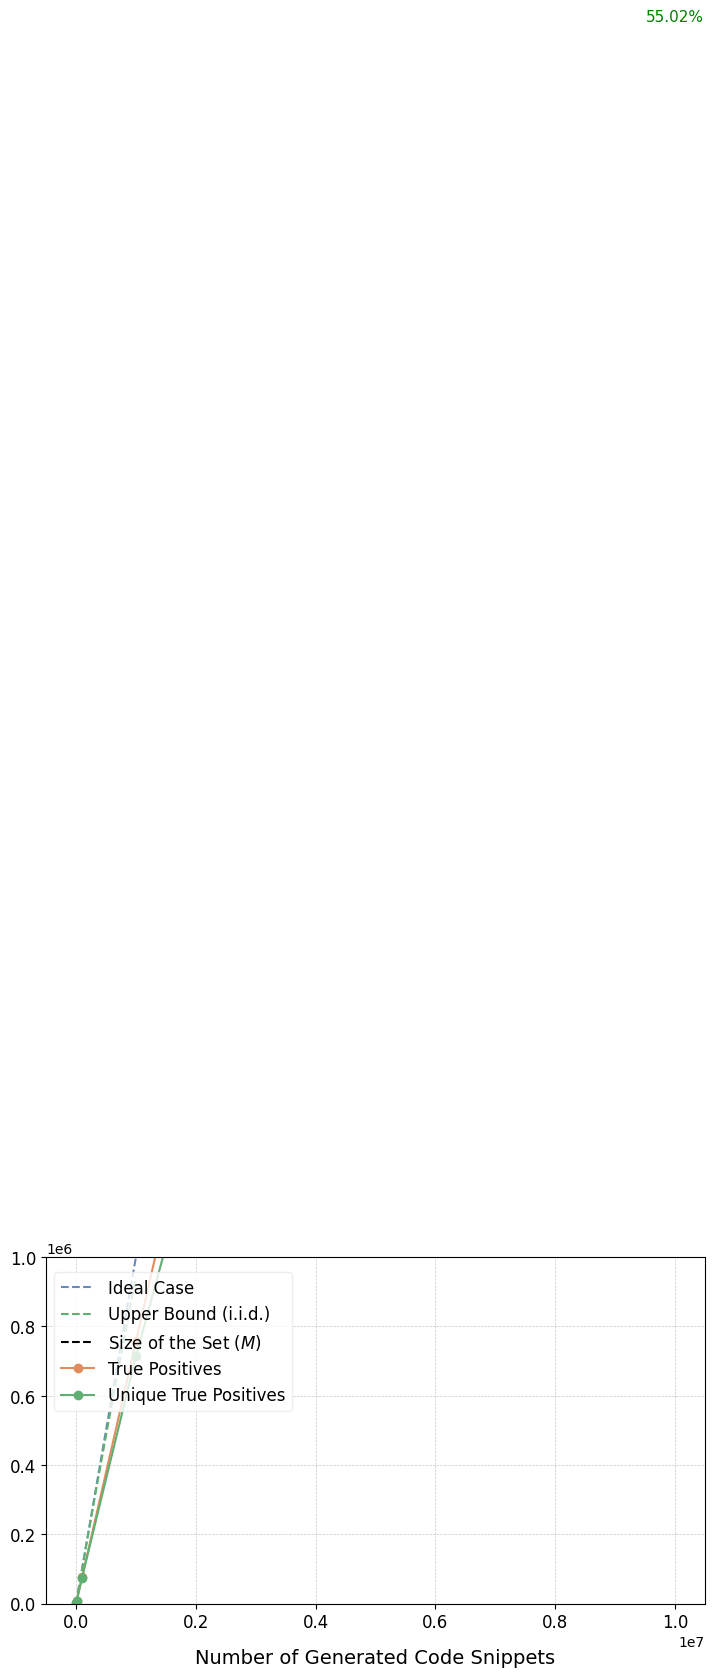

In [37]:
plot_gens_scatter(aspirin_canon_canon_df, subset_length=8284280, save = '../plots/aspirin_canon_canon_1K_10M.pdf')

In [38]:
gen_len = [0, 100_000, 400_000, 700_000, 1_000_000]

beams = {
    'Actual Duplicated TP':np.array([0, 74.58 *100000, 74.65*400000, 74.61*700000, 74.59*1000000]) / 100,
    'Actual Unique TP':np.array([0, 10.7, 34.1, 48.73, 58.23]) * 656656 / 100}

code_rand_df = pd.DataFrame(beams)
code_rand_df['Gen Length'] = gen_len

code_rand_df

,Actual Duplicated TP,Actual Unique TP,Gen Length
0,0.0,0.0000,0
1,74580.0,70262.1920,100000
2,298600.0,223919.6960,400000
3,522270.0,319988.4688,700000
4,745900.0,382370.7888,1000000


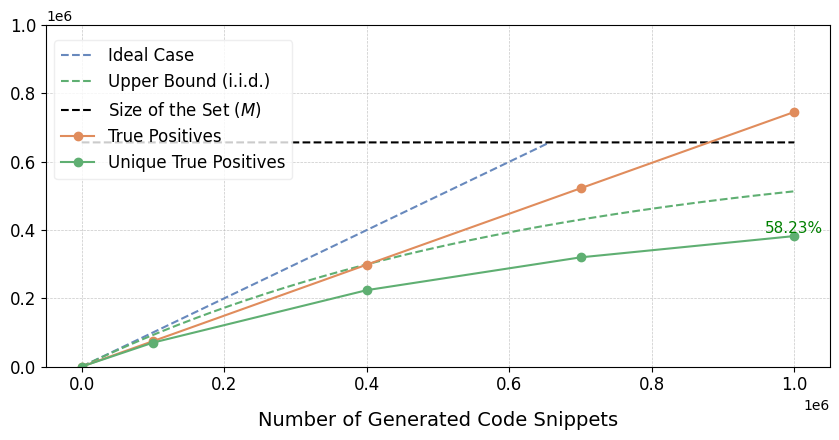

In [39]:
plot_gens_scatter(code_rand_df, subset_length=656656, save = '../plots/code_rand.pdf')

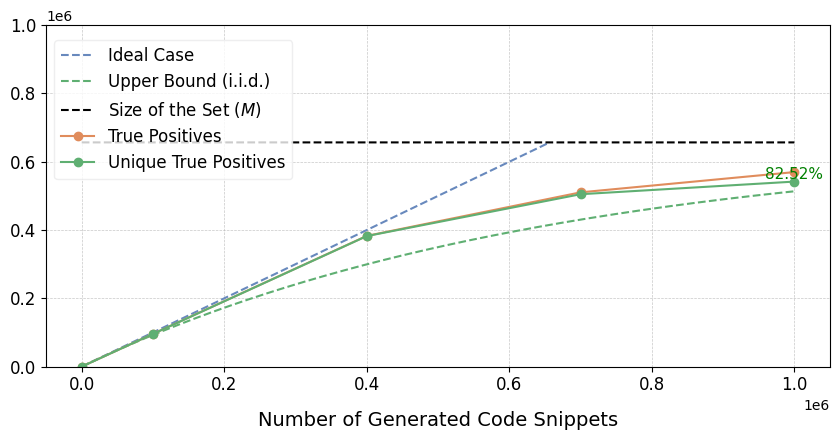

In [40]:
gen_len = [0, 100_000, 400_000, 700_000, 1_000_000]

beams = {
    'Actual Duplicated TP':np.array([0, 95.93 *100000, 95.71*400000, 72.91*700000, 56.97*1000000]) / 100,
    'Actual Unique TP':np.array([0, 14.58, 58.22, 76.89, 82.52]) * 656656 / 100}

code_rand_df = pd.DataFrame(beams)
code_rand_df['Gen Length'] = gen_len

code_rand_df
plot_gens_scatter(code_rand_df, subset_length=656656, save = '../plots/code_beam.pdf')

In [53]:
gen_len = [0, 1_000_000, 4_000_000, 7_000_000, 10_000_000]
# gen_len_str = ['1K','10K','100K','1M','2M','6M','8M', '10M']

beams = {
    'Actual Duplicated TP':np.array([0, 98.17 *1000000, 95.12*4000000, 87.49*7000000, 74.8*10000000]) / 100,
    'Actual Unique TP':np.array([0, 11.84, 45.85, 73.52, 89.05]) * 8284280 / 100}

aspirin_canon_canon_beam_df = pd.DataFrame(beams)
aspirin_canon_canon_beam_df['Gen Length'] = gen_len

aspirin_canon_canon_beam_df

,Actual Duplicated TP,Actual Unique TP,Gen Length
0,0.0,0.000,0
1,981700.0,980858.752,1000000
2,3804800.0,3798342.380,4000000
3,6124300.0,6090602.656,7000000
4,7480000.0,7377151.340,10000000


/tmp/ipykernel_1282141/1119163218.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 1])


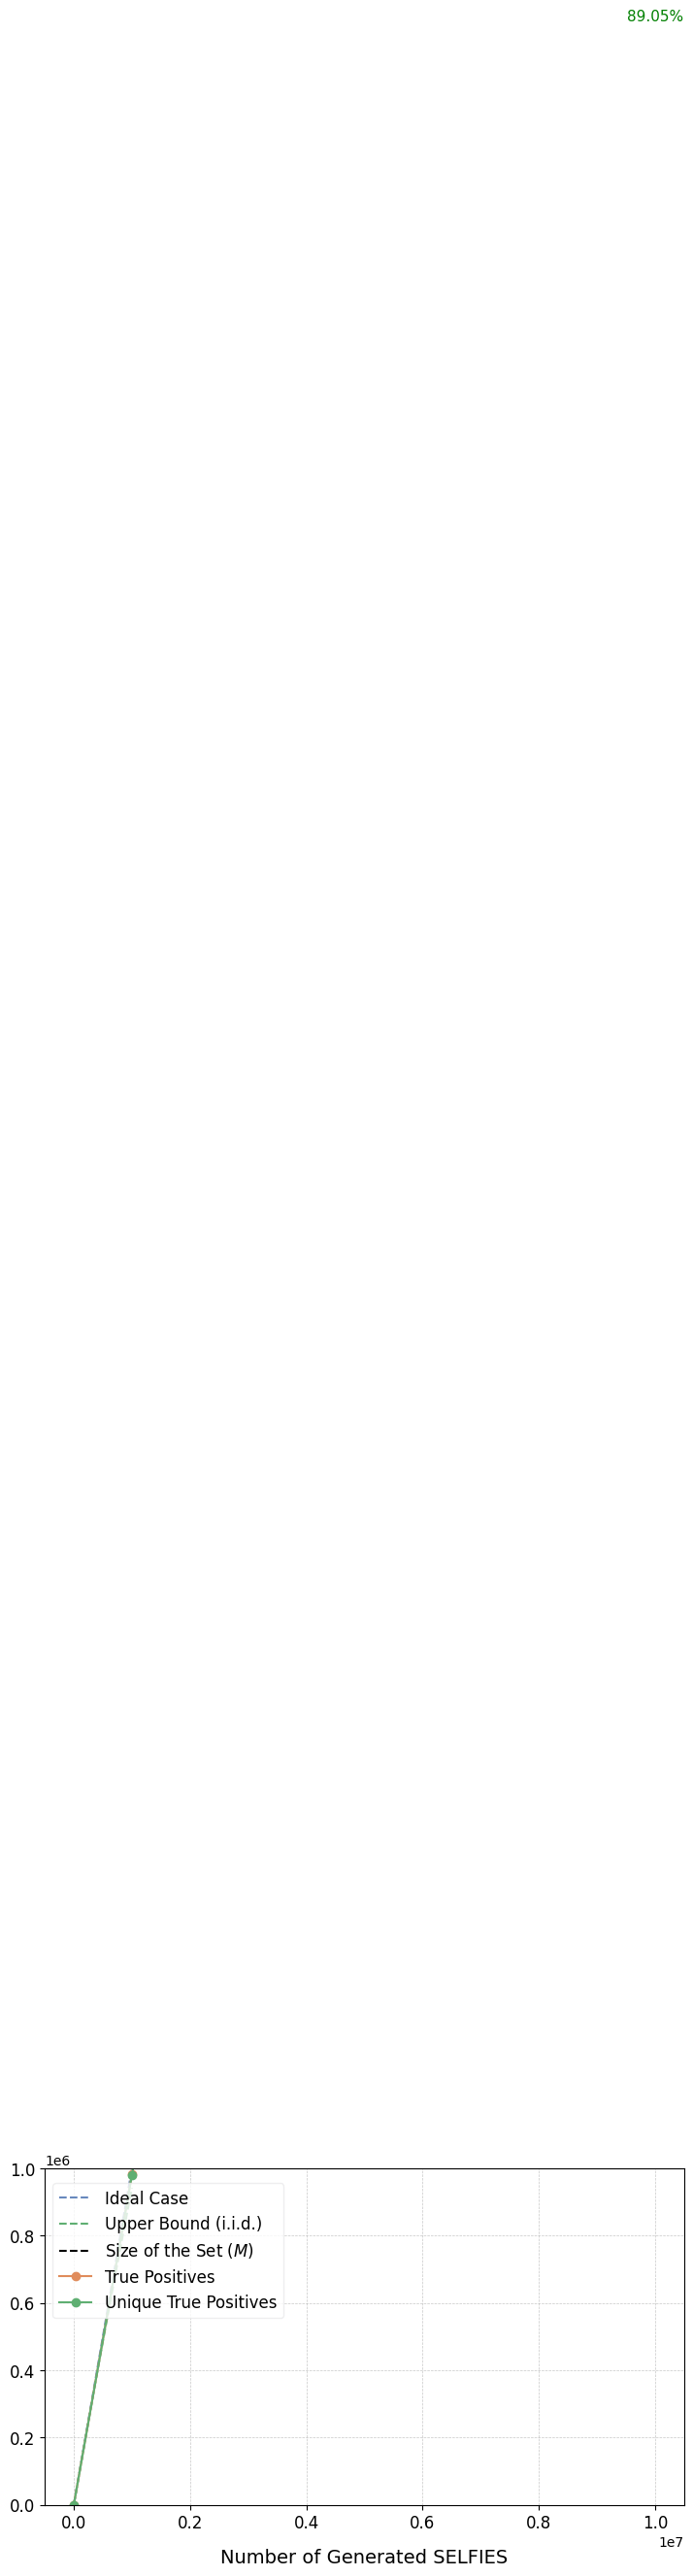

In [46]:
plot_gens_scatter(aspirin_canon_canon_beam_df, subset_length=8284280, save = '../plots/aspirin_canon_rand_1M_10M_beam.pdf')

### Sas

In [64]:
subset = 'sas'
pretrain = 'canon'
finetune = 'canon'

sas_canon_canon = [f'/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/actual_generation_statistics/selfies/{subset}/PRETRAIN_{pretrain}_FINETUNE_{finetune}_FROM_GEN_10M_GEN_LEN_{gen_len}_TEMP_1.xlsx' for gen_len in gen_lengths]

In [65]:
subset = 'sas'
pretrain = 'canon'
finetune = 'rand'

sas_canon_rand = [f'/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/actual_generation_statistics/selfies/{subset}/PRETRAIN_{pretrain}_FINETUNE_{finetune}_FROM_GEN_10M_GEN_LEN_{gen_len}_TEMP_1.xlsx' for gen_len in gen_lengths]

In [66]:
subset = 'sas'
pretrain = 'rand'
finetune = 'canon'

sas_rand_canon = [f'/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/actual_generation_statistics/selfies/{subset}/PRETRAIN_{pretrain}_FINETUNE_{finetune}_FROM_GEN_10M_GEN_LEN_{gen_len}_TEMP_1.xlsx' for gen_len in gen_lengths]

In [67]:
subset = 'sas'
pretrain = 'rand'
finetune = 'canon'

sas_rand_rand = [f'/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/actual_generation_statistics/selfies/{subset}/PRETRAIN_{pretrain}_FINETUNE_{finetune}_FROM_GEN_10M_GEN_LEN_{gen_len}_TEMP_1.xlsx' for gen_len in gen_lengths]

In [68]:
# Sas
import pandas as pd

gen_len = [1_000, 10_000, 100_000, 1_000_000, 2_000_000, 6_000_000, 8_000_000, 10_000_000]
gen_len_str = ['1K','10K','100K','1M','2M','6M','8M', '10M']

sas_canon_canon_df = pd.DataFrame()
sas_canon_rand_df = pd.DataFrame()
sas_rand_canon_df = pd.DataFrame()
sas_rand_rand_df = pd.DataFrame()

tmp = {'Actual Duplicated TP':[], 'Actual Unique TP':[]}
for file in sas_canon_canon:
    tmp['Actual Duplicated TP'].append(pd.read_excel(file)['Actual Duplicated TP'][0])
    tmp['Actual Unique TP'].append(pd.read_excel(file)['Actual Unique TP'][0])
sas_canon_canon_df = pd.DataFrame(tmp)
sas_canon_canon_df['Gen Length'] = gen_len

tmp = {'Actual Duplicated TP':[], 'Actual Unique TP':[]}
for file in sas_canon_rand:
    tmp['Actual Duplicated TP'].append(pd.read_excel(file)['Actual Duplicated TP'][0])
    tmp['Actual Unique TP'].append(pd.read_excel(file)['Actual Unique TP'][0])
sas_canon_rand_df = pd.DataFrame(tmp)
sas_canon_rand_df['Gen Length'] = gen_len

tmp = {'Actual Duplicated TP':[], 'Actual Unique TP':[]}
for file in sas_rand_canon:
    tmp['Actual Duplicated TP'].append(pd.read_excel(file)['Actual Duplicated TP'][0])
    tmp['Actual Unique TP'].append(pd.read_excel(file)['Actual Unique TP'][0])
sas_rand_canon_df = pd.DataFrame(tmp)
sas_rand_canon_df['Gen Length'] = gen_len

tmp = {'Actual Duplicated TP':[], 'Actual Unique TP':[]}
for file in sas_rand_rand:
    tmp['Actual Duplicated TP'].append(pd.read_excel(file)['Actual Duplicated TP'][0])
    tmp['Actual Unique TP'].append(pd.read_excel(file)['Actual Unique TP'][0])
sas_rand_rand_df = pd.DataFrame(tmp)
sas_rand_rand_df['Gen Length'] = gen_len

print(sas_canon_canon_df, sas_canon_rand_df, sas_rand_canon_df, sas_rand_rand_df)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/actual_generation_statistics/selfies/sas/PRETRAIN_canon_FINETUNE_canon_FROM_GEN_10M_GEN_LEN_1000_TEMP_1.xlsx'

In [69]:
plot_gens_scatter(sas_canon_canon_df, subset_length = 6645440, save = '/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/plots/sas_canon_canon_1K_10M.pdf')

KeyError: 'Actual Duplicated TP'

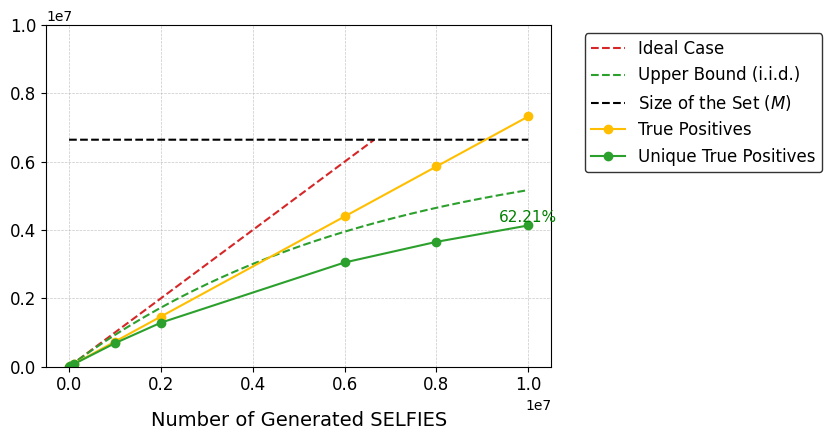

In [100]:
plot_gens_scatter(sas_canon_rand_df, subset_length = 6645440, save = '/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/plots/sas_canon_rand_1K_10M.pdf')

In [70]:
plot_gens_scatter(sas_rand_canon_df, subset_length = 6645440, save = '/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/plots/sas_rand_canon_1K_10M.pdf')

KeyError: 'Actual Duplicated TP'

In [71]:
plot_gens_scatter(sas_rand_rand_df, subset_length = 6645440, save = '/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/plots/sas_rand_rand_1K_10M.pdf')

KeyError: 'Actual Duplicated TP'

### Druglike

In [72]:
subset = 'druglike'
pretrain = 'canon'
finetune = 'canon'

druglike_canon_canon = [f'/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/actual_generation_statistics/selfies/{subset}/PRETRAIN_{pretrain}_FINETUNE_{finetune}_FROM_GEN_10M_GEN_LEN_{gen_len}_TEMP_1.xlsx' for gen_len in gen_lengths]

In [105]:
subset = 'druglike'
pretrain = 'canon'
finetune = 'canon'

druglike_canon_rand = [f'/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/actual_generation_statistics/selfies/{subset}/PRETRAIN_{pretrain}_FINETUNE_{finetune}_FROM_GEN_10M_GEN_LEN_{gen_len}_TEMP_1.xlsx' for gen_len in gen_lengths]

In [106]:
subset = 'druglike'
pretrain = 'rand'
finetune = 'canon'

druglike_rand_canon = [f'/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/actual_generation_statistics/selfies/{subset}/PRETRAIN_{pretrain}_FINETUNE_{finetune}_FROM_GEN_10M_GEN_LEN_{gen_len}_TEMP_1.xlsx' for gen_len in gen_lengths]

In [107]:
subset = 'druglike'
pretrain = 'rand'
finetune = 'rand'

druglike_rand_rand = [f'/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/actual_generation_statistics/selfies/{subset}/PRETRAIN_{pretrain}_FINETUNE_{finetune}_FROM_GEN_10M_GEN_LEN_{gen_len}_TEMP_1.xlsx' for gen_len in gen_lengths]

In [108]:
# Druglike
import pandas as pd

gen_len = [1_000, 10_000, 100_000, 1_000_000, 2_000_000, 6_000_000, 8_000_000, 10_000_000]
gen_len_str = ['1K','10K','100K','1M','2M','6M','8M', '10M']

druglike_canon_canon_df = pd.DataFrame()
druglike_canon_rand_df = pd.DataFrame()
druglike_rand_canon_df = pd.DataFrame()
druglike_rand_rand_df = pd.DataFrame()

tmp = {'Actual Duplicated TP':[], 'Actual Unique TP':[]}
for file in druglike_canon_canon:
    tmp['Actual Duplicated TP'].append(pd.read_excel(file)['Actual Duplicated TP'][0])
    tmp['Actual Unique TP'].append(pd.read_excel(file)['Actual Unique TP'][0])
druglike_canon_canon_df = pd.DataFrame(tmp)
druglike_canon_canon_df['Gen Length'] = gen_len

tmp = {'Actual Duplicated TP':[], 'Actual Unique TP':[]}
for file in druglike_canon_rand:
    tmp['Actual Duplicated TP'].append(pd.read_excel(file)['Actual Duplicated TP'][0])
    tmp['Actual Unique TP'].append(pd.read_excel(file)['Actual Unique TP'][0])
druglike_canon_rand_df = pd.DataFrame(tmp)
druglike_canon_rand_df['Gen Length'] = gen_len

tmp = {'Actual Duplicated TP':[], 'Actual Unique TP':[]}
for file in druglike_rand_canon:
    tmp['Actual Duplicated TP'].append(pd.read_excel(file)['Actual Duplicated TP'][0])
    tmp['Actual Unique TP'].append(pd.read_excel(file)['Actual Unique TP'][0])
druglike_rand_canon_df = pd.DataFrame(tmp)
druglike_rand_canon_df['Gen Length'] = gen_len

tmp = {'Actual Duplicated TP':[], 'Actual Unique TP':[]}
for file in druglike_rand_rand:
    tmp['Actual Duplicated TP'].append(pd.read_excel(file)['Actual Duplicated TP'][0])
    tmp['Actual Unique TP'].append(pd.read_excel(file)['Actual Unique TP'][0])
druglike_rand_rand_df = pd.DataFrame(tmp)
druglike_rand_rand_df['Gen Length'] = gen_len

print(druglike_canon_canon_df, druglike_canon_rand_df, druglike_rand_canon_df, druglike_rand_rand_df)

   Actual Duplicated TP  Actual Unique TP  Gen Length
0                   688               688        1000
1                  6850              6843       10000
2                 68462             68108      100000
3                683074            648842     1000000
4               1366165           1234729     2000000
5               4096055           3081152     6000000
6               5461631           3780925     8000000
7               6827435           4369476    10000000    Actual Duplicated TP  Actual Unique TP  Gen Length
0                   688               688        1000
1                  6850              6843       10000
2                 68462             68108      100000
3                683074            648842     1000000
4               1366165           1234729     2000000
5               4096055           3081152     6000000
6               5461631           3780925     8000000
7               6827435           4369476    10000000    Actual Duplicated TP  Act

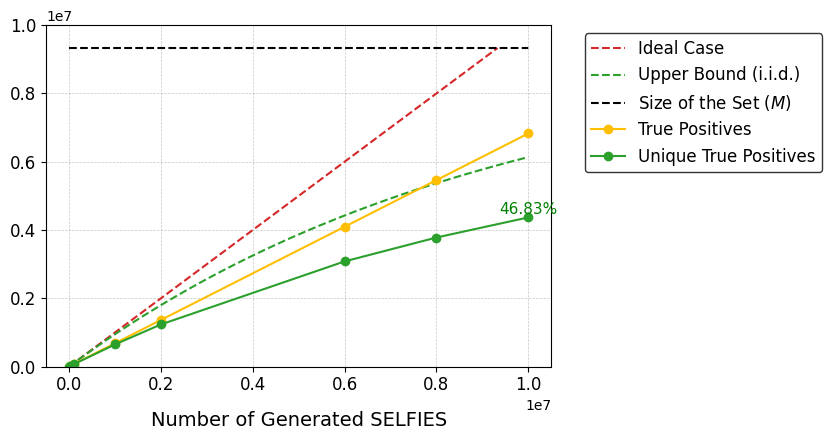

In [109]:
plot_gens_scatter(druglike_canon_canon_df, subset_length=9331077, save = '/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/plots/druglike_canon_canon_1K_10M.pdf')

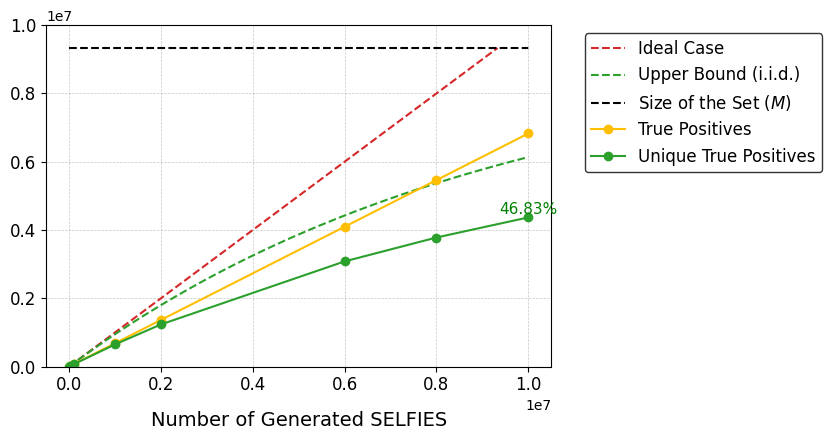

In [110]:
plot_gens_scatter(druglike_canon_rand_df, subset_length=9331077, save = '/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/plots/druglike_canon_rand_1K_10M.pdf')

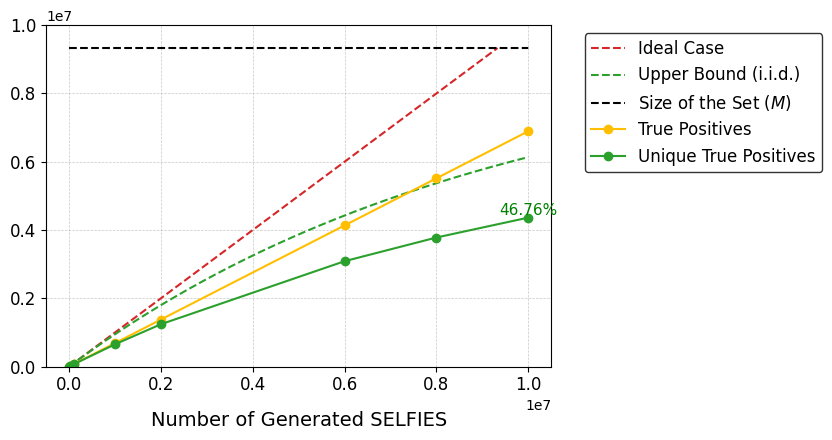

In [111]:
plot_gens_scatter(druglike_rand_canon_df, subset_length=9331077, save = '/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/plots/druglike_rand_canon_1K_10M.pdf')

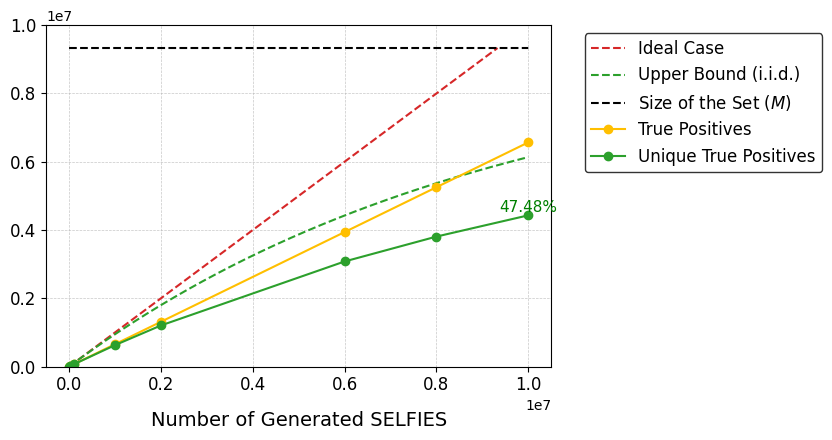

In [112]:
plot_gens_scatter(druglike_rand_rand_df, subset_length=9331077, save = '/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/plots/druglike_rand_rand_1K_10M.pdf')

### Eqdist

In [113]:
subset = 'eqdist'
pretrain = 'canon'
finetune = 'canon'

eqdist_canon_canon = [f'/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/actual_generation_statistics/selfies/{subset}/PRETRAIN_{pretrain}_FINETUNE_{finetune}_FROM_GEN_10M_GEN_LEN_{gen_len}_TEMP_1.xlsx' for gen_len in gen_lengths]

In [114]:
subset = 'eqdist'
pretrain = 'canon'
finetune = 'rand'

eqdist_canon_rand = [f'/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/actual_generation_statistics/selfies/{subset}/PRETRAIN_{pretrain}_FINETUNE_{finetune}_FROM_GEN_10M_GEN_LEN_{gen_len}_TEMP_1.xlsx' for gen_len in gen_lengths]

In [115]:
subset = 'eqdist'
pretrain = 'rand'
finetune = 'canon'

eqdist_rand_canon = [f'/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/actual_generation_statistics/selfies/{subset}/PRETRAIN_{pretrain}_FINETUNE_{finetune}_FROM_GEN_10M_GEN_LEN_{gen_len}_TEMP_1.xlsx' for gen_len in gen_lengths]

In [116]:
subset = 'eqdist'
pretrain = 'rand'
finetune = 'rand'

eqdist_rand_rand = [f'/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/actual_generation_statistics/selfies/{subset}/PRETRAIN_{pretrain}_FINETUNE_{finetune}_FROM_GEN_10M_GEN_LEN_{gen_len}_TEMP_1.xlsx' for gen_len in gen_lengths]

In [117]:
# Eqdist
import pandas as pd

gen_len = [1_000, 10_000, 100_000, 1_000_000, 2_000_000, 6_000_000, 8_000_000, 10_000_000]
gen_len_str = ['1K','10K','100K','1M','2M','6M','8M', '10M']

eqdist_canon_canon_df = pd.DataFrame()
eqdist_canon_rand_df = pd.DataFrame()
eqdist_rand_canon_df = pd.DataFrame()
eqdist_rand_rand_df = pd.DataFrame()

tmp = {'Actual Duplicated TP':[], 'Actual Unique TP':[]}
for file in eqdist_canon_canon:
    tmp['Actual Duplicated TP'].append(pd.read_excel(file)['Actual Duplicated TP'][0])
    tmp['Actual Unique TP'].append(pd.read_excel(file)['Actual Unique TP'][0])
eqdist_canon_canon_df = pd.DataFrame(tmp)
eqdist_canon_canon_df['Gen Length'] = gen_len

tmp = {'Actual Duplicated TP':[], 'Actual Unique TP':[]}
for file in eqdist_canon_rand:
    tmp['Actual Duplicated TP'].append(pd.read_excel(file)['Actual Duplicated TP'][0])
    tmp['Actual Unique TP'].append(pd.read_excel(file)['Actual Unique TP'][0])
eqdist_canon_rand_df = pd.DataFrame(tmp)
eqdist_canon_rand_df['Gen Length'] = gen_len

tmp = {'Actual Duplicated TP':[], 'Actual Unique TP':[]}
for file in eqdist_rand_canon:
    tmp['Actual Duplicated TP'].append(pd.read_excel(file)['Actual Duplicated TP'][0])
    tmp['Actual Unique TP'].append(pd.read_excel(file)['Actual Unique TP'][0])
eqdist_rand_canon_df = pd.DataFrame(tmp)
eqdist_rand_canon_df['Gen Length'] = gen_len

tmp = {'Actual Duplicated TP':[], 'Actual Unique TP':[]}
for file in eqdist_rand_rand:
    tmp['Actual Duplicated TP'].append(pd.read_excel(file)['Actual Duplicated TP'][0])
    tmp['Actual Unique TP'].append(pd.read_excel(file)['Actual Unique TP'][0])
eqdist_rand_rand_df = pd.DataFrame(tmp)
eqdist_rand_rand_df['Gen Length'] = gen_len

# print(eqdist_canon_canon_df, eqdist_canon_rand_df, eqdist_rand_canon_df, eqdist_rand_rand_df)

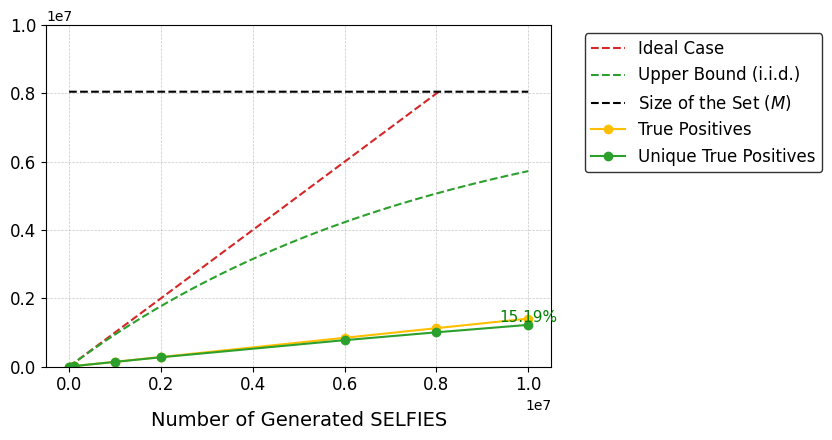

In [118]:
plot_gens_scatter(eqdist_canon_canon_df, subset_length=8051185, save = '/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/plots/eqdist_canon_canon_1K_10M.pdf')

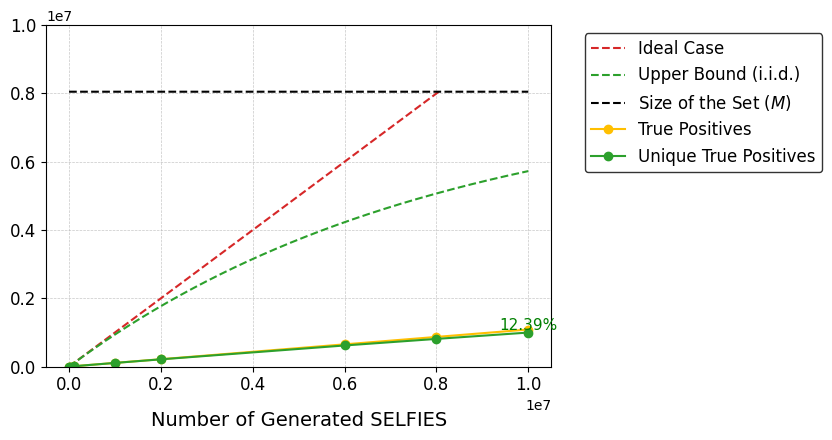

In [119]:
plot_gens_scatter(eqdist_canon_rand_df, subset_length=8051185, save = '/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/plots/eqdist_canon_rand_1K_10M.pdf')

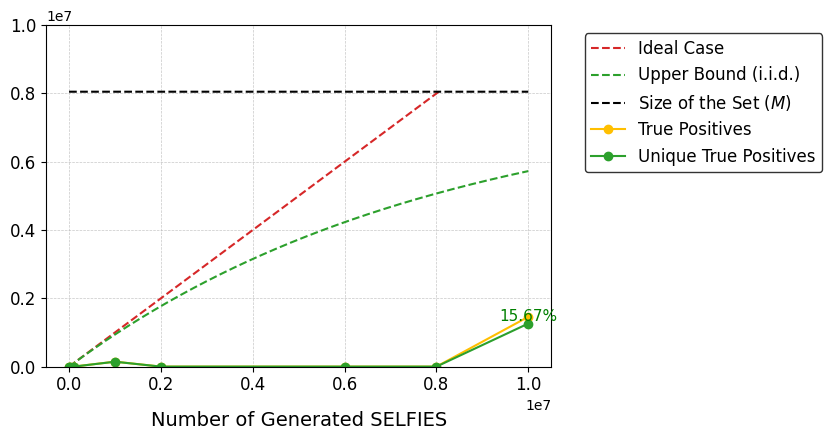

In [120]:
plot_gens_scatter(eqdist_rand_canon_df, subset_length=8051185, save = '/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/plots/eqdist_rand_canon_1K_10M.pdf')

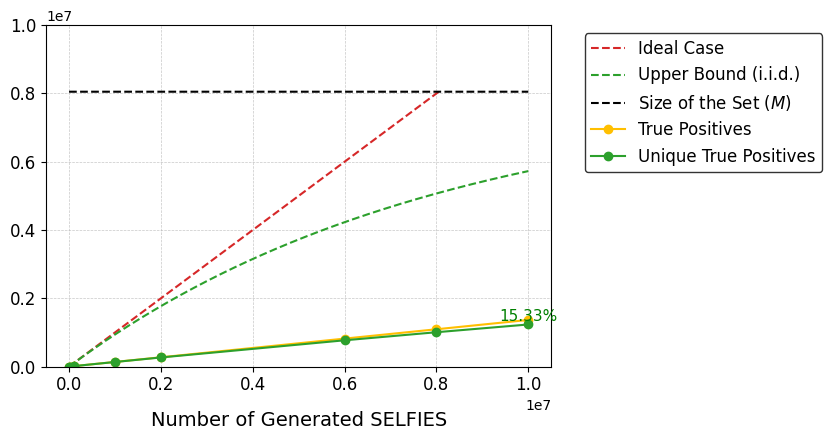

In [121]:
plot_gens_scatter(eqdist_rand_rand_df, subset_length=8051185, save = '/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/plots/eqdist_rand_rand_1K_10M.pdf')

## Predictions on 1K,5K,10K Validations

In [132]:
main_directory = '/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/predicted_generation_statistics/selfies'
subsets = ['aspirin', 'sas', 'druglike', 'eqdist']

canon_canon = {'1K': 'PRETRAIN_canon_FINETUNE_canon_GEN_LEN_1M_VALID_LEN_1000_TEMP_1.xlsx', '5K': 'PRETRAIN_canon_FINETUNE_canon_GEN_LEN_1M_VALID_LEN_5000_TEMP_1.xlsx', '10K':'PRETRAIN_canon_FINETUNE_canon_GEN_LEN_1M_VALID_LEN_10000_TEMP_1.xlsx'}
canon_rand = {'1K': 'PRETRAIN_canon_FINETUNE_rand_GEN_LEN_1M_VALID_LEN_1000_TEMP_1.xlsx', '5K': 'PRETRAIN_canon_FINETUNE_rand_GEN_LEN_1M_VALID_LEN_5000_TEMP_1.xlsx', '10K':'PRETRAIN_canon_FINETUNE_rand_GEN_LEN_1M_VALID_LEN_10000_TEMP_1.xlsx'}
rand_canon = {'1K': 'PRETRAIN_rand_FINETUNE_canon_GEN_LEN_1M_VALID_LEN_1000_TEMP_1.xlsx', '5K': 'PRETRAIN_rand_FINETUNE_canon_GEN_LEN_1M_VALID_LEN_5000_TEMP_1.xlsx', '10K':'PRETRAIN_rand_FINETUNE_canon_GEN_LEN_1M_VALID_LEN_10000_TEMP_1.xlsx'}
rand_rand = {'1K': 'PRETRAIN_rand_FINETUNE_rand_GEN_LEN_1M_VALID_LEN_1000_TEMP_1.xlsx', '5K': 'PRETRAIN_rand_FINETUNE_rand_GEN_LEN_1M_VALID_LEN_5000_TEMP_1.xlsx', '10K':'PRETRAIN_rand_FINETUNE_rand_GEN_LEN_1M_VALID_LEN_10000_TEMP_1.xlsx'}

stats = [canon_canon, canon_rand, rand_canon, rand_rand]
valid_lens = ['1K', '5K', '10K']

aspirin_df = pd.DataFrame()
sas_df = pd.DataFrame()
druglike_df = pd.DataFrame()
eqdist_df = pd.DataFrame()

for model in stats:
    for valid_len in valid_lens:
        aspirin_path = main_directory + '/' + 'aspirin' + '/'+ model[valid_len]
        sas_path = main_directory + '/' + 'sas' + '/'+ model[valid_len]
        druglike_path = main_directory + '/' + 'druglike' + '/'+ model[valid_len]
        eqdist_path = main_directory + '/' + 'eqdist' + '/'+ model[valid_len]

        aspirin_df = pd.concat([aspirin_df,pd.read_excel(aspirin_path)])
        sas_df = pd.concat([sas_df,pd.read_excel(sas_path)])
        druglike_df = pd.concat([druglike_df,pd.read_excel(druglike_path)])
        eqdist_df = pd.concat([eqdist_df,pd.read_excel(eqdist_path)])

        aspirin_df = aspirin_df.reset_index(drop=True)
        sas_df = sas_df.reset_index(drop=True)
        druglike_df = druglike_df.reset_index(drop=True)
        eqdist_df = eqdist_df.reset_index(drop=True)
        


In [123]:
def make_tabels(aspirin_df, sas_df, druglike_df, eqdist_df):
    models = {'canon_canon':2, 'canon_rand':5, 'rand_canon':8, 'rand_rand':11}
    for model in models:
        print('The model is:', model)
        a = aspirin_df[aspirin_df['Validation Length']==10000].loc[models[model]]
        b = sas_df[sas_df['Validation Length']==10000].loc[models[model]]
        c = druglike_df[druglike_df['Validation Length']==10000].loc[models[model]]
        d = eqdist_df[eqdist_df['Validation Length']==10000].loc[models[model]]
        metrics = pd.concat([a,b,c,d], axis=1).T
        PATH = f'/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/general_statistics/{model}.xlsx'
        print(metrics)
        # metrics.to_excel(PATH, index=False)

In [51]:
# path = '/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13_my/src/statistics/new_general_statistics/rand_canon.xlsx'
# pd.read_excel(path)

In [124]:
make_tabels(aspirin_df, sas_df, druglike_df, eqdist_df)

The model is: canon_canon
     Subset Actual Duplicated TP Predicted Duplicated TP Diff Duplicated TP  \
2   aspirin               756477                  739939              16538   
2       sas               805514                  799113               6401   
2  druglike               683074                  665395              17679   
2    eqdist               140421                  135075               5346   

  Actual Unique TP Predicted Unique TP Diff Unique TP Validation Length  \
2           713478              698421          15057             10000   
2           747632              741846           5786             10000   
2           648842              632650          16192             10000   
2           138420              133129           5291             10000   

  Sum Probs  
2  0.000893  
2  0.001202  
2  0.000713  
2  0.000168  
The model is: canon_rand
     Subset Actual Duplicated TP Predicted Duplicated TP Diff Duplicated TP  \
5   aspirin               70

In [125]:
def plot_valid_scatter(pretrain, finetune, subset, df):
    diff_dup_tp = list(df['Diff Duplicated TP'])
    diff_uniq_tp = list(df['Diff Unique TP'])
    valid = list(df['Validation Length'])

    plt.plot(valid, diff_dup_tp, marker='o', linestyle='-')
    plt.plot(valid, diff_uniq_tp, marker='o', linestyle='-')

    plt.xlabel('Validation Length')
    plt.ylabel('Differences')
    plt.title(f'Subset: {subset}, Pre-Train:{pretrain}, Fine-Tune:{finetune}')

    plt.grid(True)
    plt.legend(['Diff Duplicated TP','Diff Unique TP'])
    plt.show()

In [126]:
def plot_valid_stats(subset,df):
    plot_valid_scatter('canon', 'canon', subset,df[0:3])
    plot_valid_scatter('canon', 'rand', subset,df[3:6])
    plot_valid_scatter('rand', 'canon', subset,df[6:9])
    plot_valid_scatter('rand', 'rand', subset,df[9:12])

### Aspirin

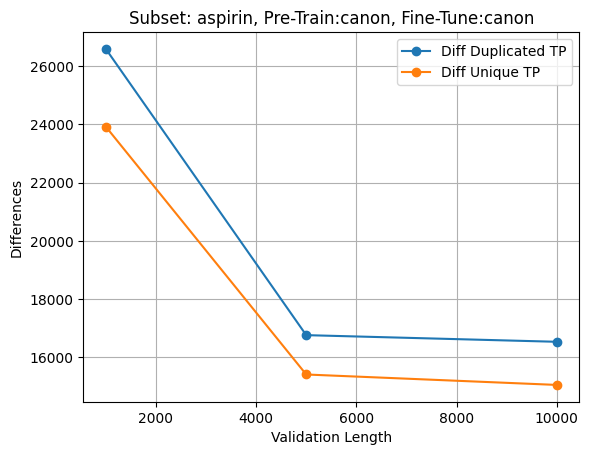

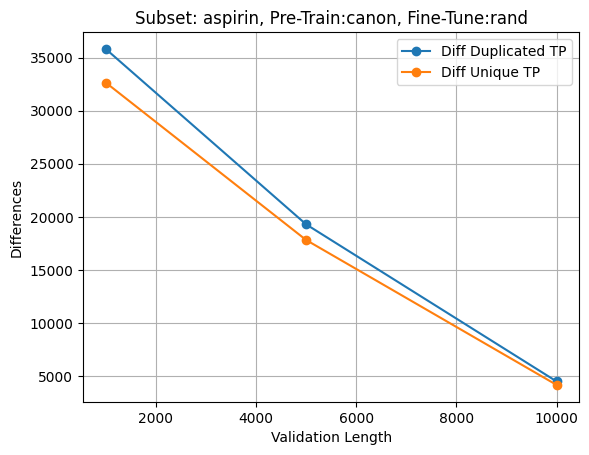

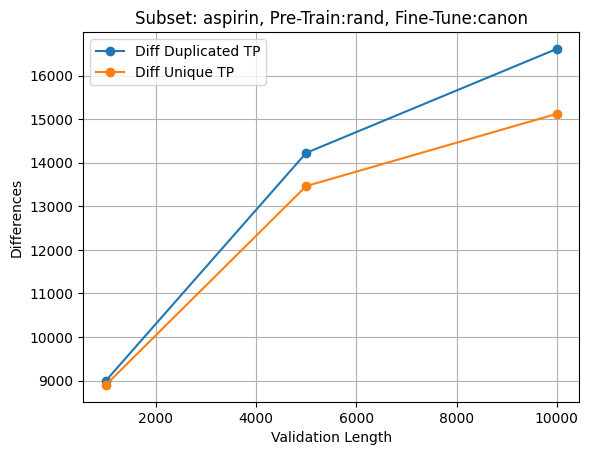

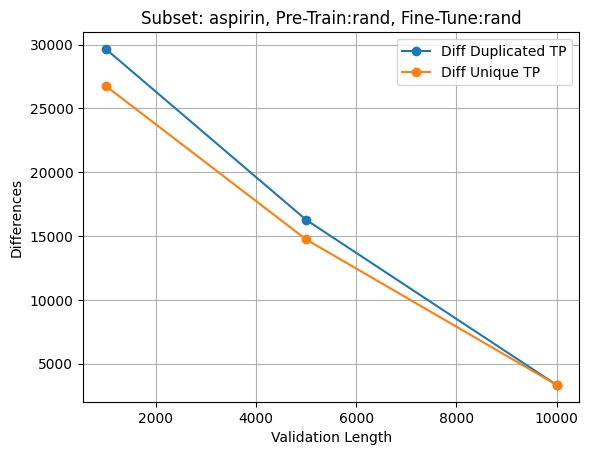

In [127]:
plot_valid_stats('aspirin', aspirin_df)

### Sas

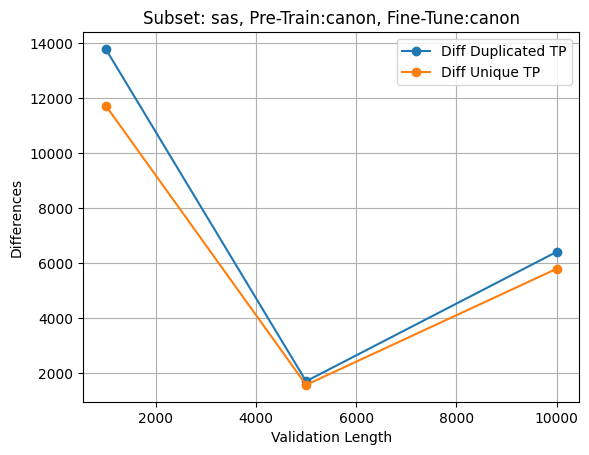

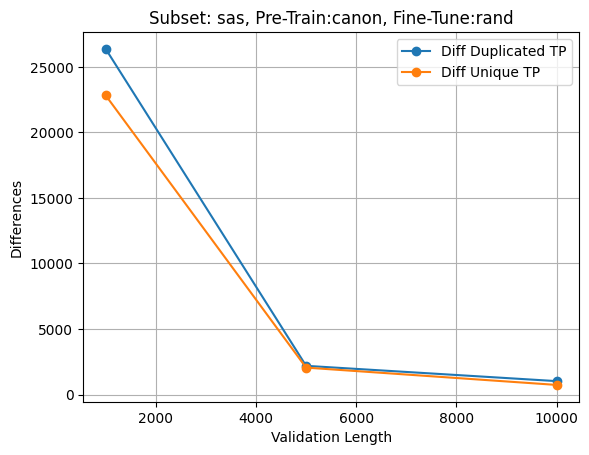

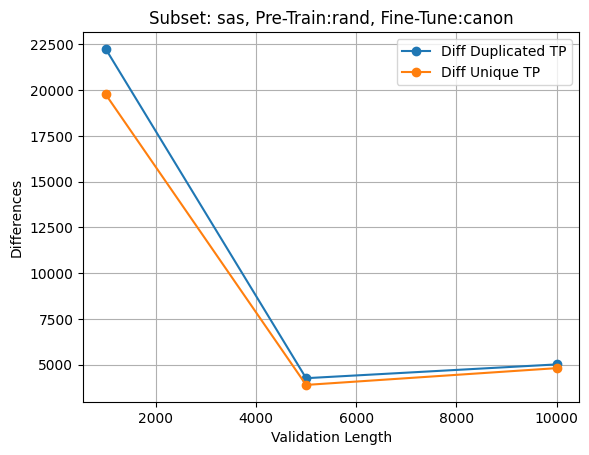

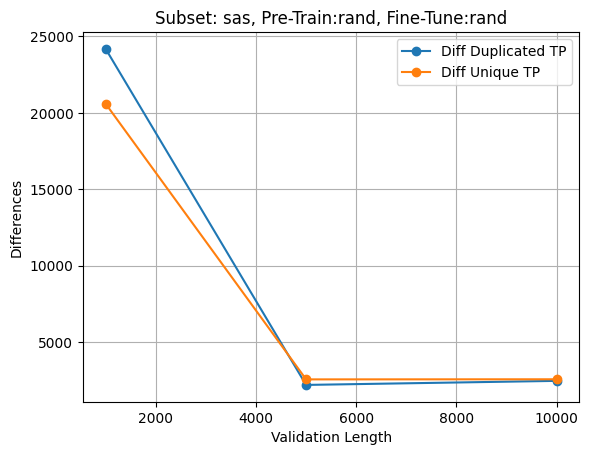

In [128]:
plot_valid_stats('sas', sas_df)

### Druglike

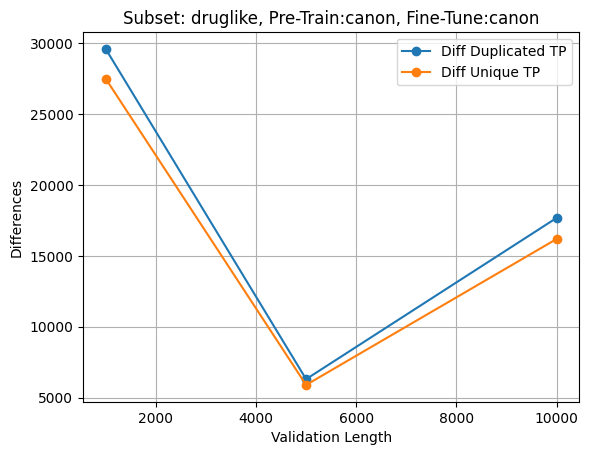

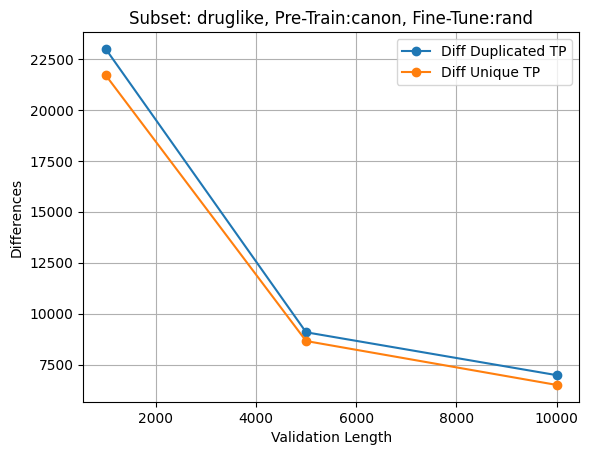

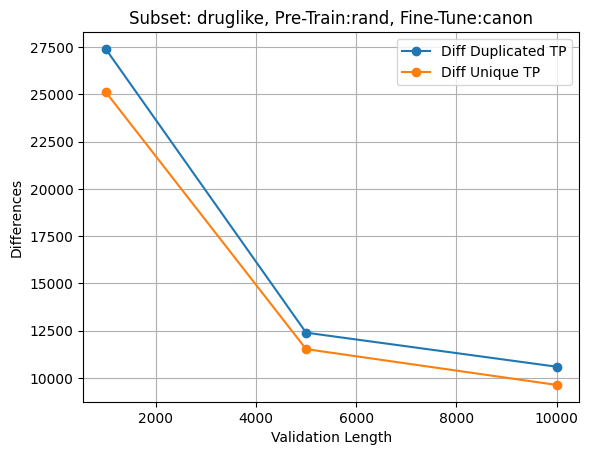

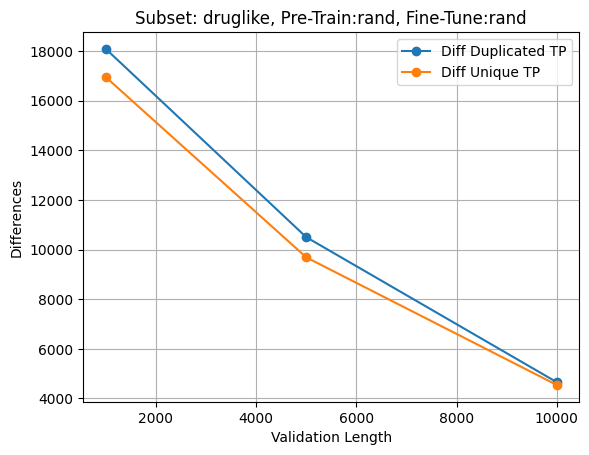

In [129]:
plot_valid_stats('druglike', druglike_df)

### Eqdist

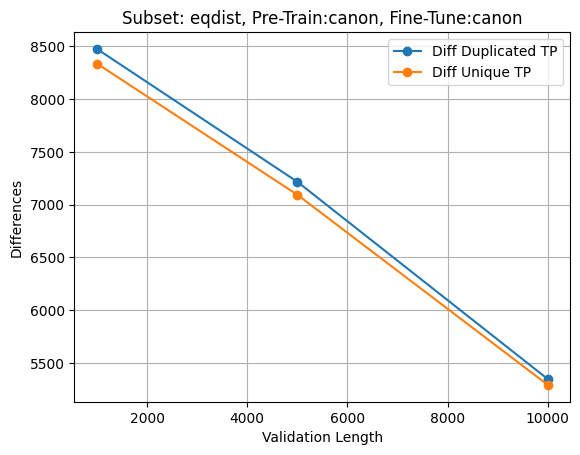

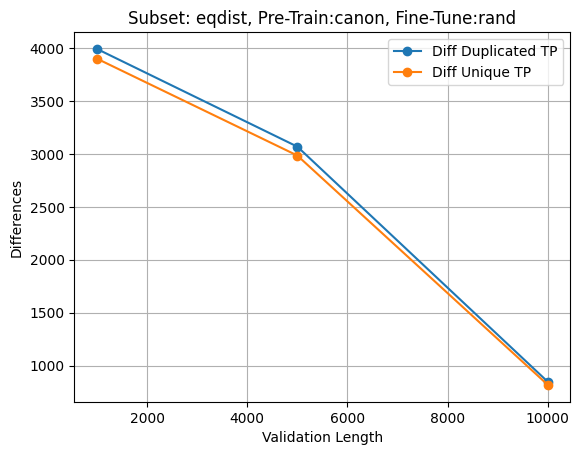

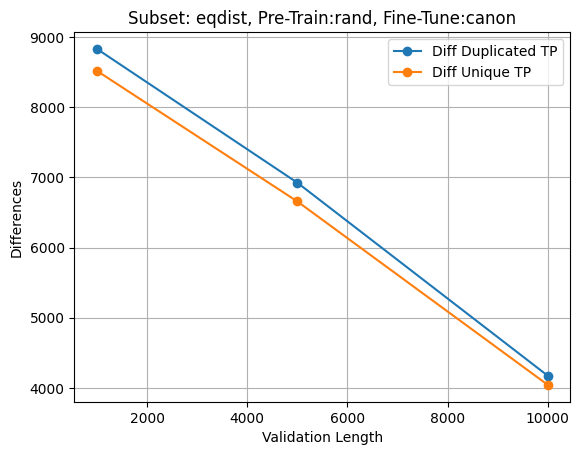

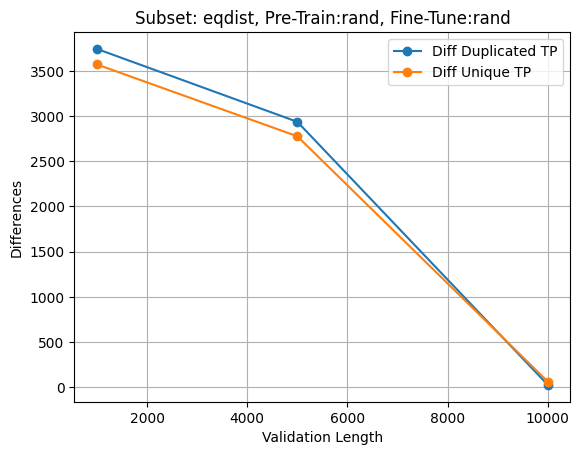

In [130]:
plot_valid_stats('eqdist', eqdist_df)

In [131]:
eqdist_df[eqdist_df['Validation Length']==10000]

,Subset,Actual Duplicated TP,Predicted Duplicated TP,Diff Duplicated TP,Actual Unique TP,Predicted Unique TP,Diff Unique TP,Validation Length,Sum Probs
2,eqdist,140421,135075,5346,138420,133129,5291,10000,0.000168
5,eqdist,108781,107934,847,107819,107001,818,10000,0.000134
8,eqdist,145357,141184,4173,143095,139052,4043,10000,0.000175
11,eqdist,136743,136718,25,135225,135286,61,10000,0.000170


## Validation randomized SELFIES

In [133]:
aspirin = '/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/ablations/validations/selfies/valid_canon_canon/aspirin/probs.csv'
sas = '/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/ablations/validations/selfies/valid_canon_canon/sas/probs.csv'
druglike = '/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/ablations/validations/selfies/valid_canon_canon/druglike/probs.csv'
eqdist = '/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/ablations/validations/selfies/valid_canon_canon/eqdist/probs.csv'

In [134]:
def plot_rand_count_hist(valid_path):
    aspirin_df = pd.read_csv(valid_path)
    length = aspirin_df.shape[0]
    aspirin_df['Count'] = np.ones(length)
    count = (aspirin_df.groupby('Name')['Count'].sum()).to_list()
    plt.hist(count, bins=100)
    min_value = min(count)
    max_value = max(count)
    mean_value = sum(count)/10_000
    plt.plot([min_value,min_value],[0,2500])
    plt.plot([max_value,max_value],[0,2500])
    plt.plot([mean_value,mean_value],[0,2500])

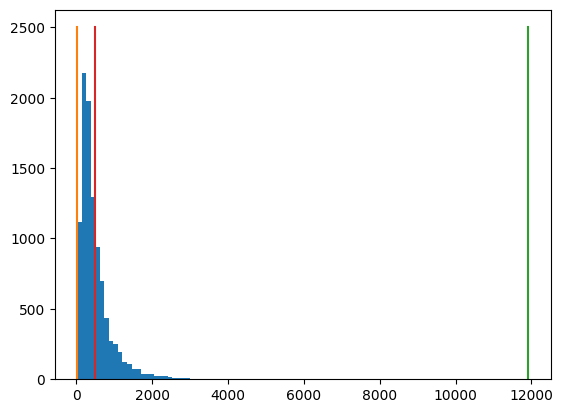

In [135]:
plot_rand_count_hist(aspirin)

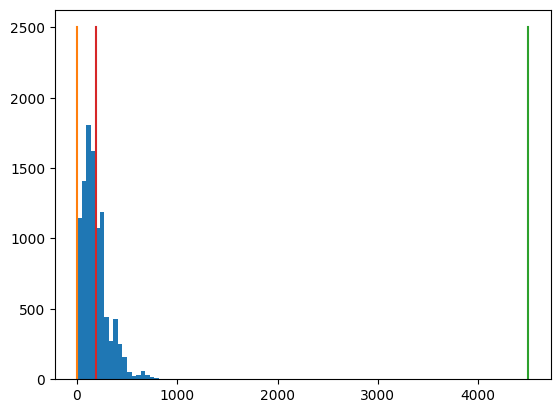

In [136]:
plot_rand_count_hist(sas)

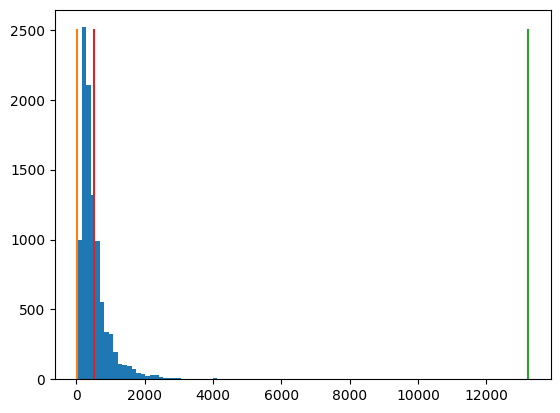

In [137]:
plot_rand_count_hist(druglike)

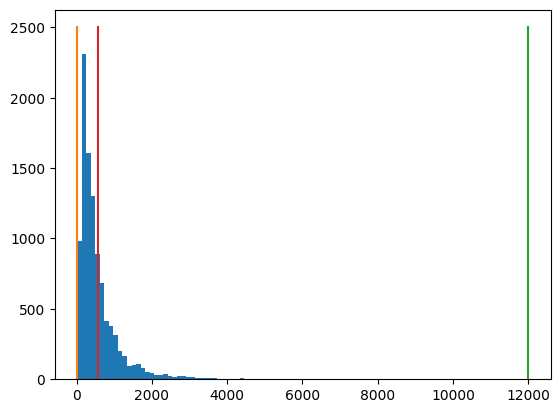

In [138]:
plot_rand_count_hist(eqdist)

## Predictions for M generations

In [3]:
subset = ['aspirin', 'sas', 'druglike', 'eqdist']
pretrain = ['canon', 'rand']
finetune = ['canon', 'rand']

df = pd.DataFrame([])
for s in subset:
    for p in pretrain:
        for f in finetune:
            print('Subset:', s)
            print('Pretrain:', p)
            print('Finetune:', f)
            df = pd.concat((df,pd.read_excel(f"/nfs/c9/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/predicted_generation_statistics/selfies/{s}/PRETRAIN_{p}_FINETUNE_{f}_GEN_LEN_8M_VALID_LEN_10000_TEMP_1.xlsx" )), axis=0)

Subset: aspirin
Pretrain: canon
Finetune: canon
Subset: aspirin
Pretrain: canon
Finetune: rand
Subset: aspirin
Pretrain: rand
Finetune: canon
Subset: aspirin
Pretrain: rand
Finetune: rand
Subset: sas
Pretrain: canon
Finetune: canon
Subset: sas
Pretrain: canon
Finetune: rand
Subset: sas
Pretrain: rand
Finetune: canon
Subset: sas
Pretrain: rand
Finetune: rand
Subset: druglike
Pretrain: canon
Finetune: canon
Subset: druglike
Pretrain: canon
Finetune: rand
Subset: druglike
Pretrain: rand
Finetune: canon
Subset: druglike
Pretrain: rand
Finetune: rand
Subset: eqdist
Pretrain: canon
Finetune: canon
Subset: eqdist
Pretrain: canon
Finetune: rand
Subset: eqdist
Pretrain: rand
Finetune: canon
Subset: eqdist
Pretrain: rand
Finetune: rand


In [4]:
aspirin = [8284280]*4  
sas = [6645440]*4 
druglike = [9331077]*4  
eqdist = [8051185]*4
subset_length = aspirin + sas  + druglike + eqdist
subset_length

[8284280,
 8284280,
 8284280,
 8284280,
 6645440,
 6645440,
 6645440,
 6645440,
 9331077,
 9331077,
 9331077,
 9331077,
 8051185,
 8051185,
 8051185,
 8051185]

In [5]:
df = df.drop(columns=['Actual Duplicated TP','Diff Duplicated TP',	'Actual Unique TP', 'Diff Unique TP', 'Validation Length', 'Sum Probs'])
df['Subset Length'] = subset_length
df['Recall'] = round((df['Predicted Unique TP']/df['Subset Length'])*100,2)
# df.to_excel('/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13_my/src/statistics/predicted_generation_statistics/selfies/generation_subset_length.xlsx', index=False)
df

,Subset,Predicted Duplicated TP,Predicted Unique TP,Subset Length,Recall
0,aspirin,6129862,4006298,8284280,48.36
0,aspirin,5813255,3941328,8284280,47.58
0,aspirin,6176658,3993956,8284280,48.21
0,aspirin,6198695,4152079,8284280,50.12
0,sas,6620077,3883289,6645440,58.44
0,sas,6079218,3737469,6645440,56.24
0,sas,6608991,3852505,6645440,57.97
0,sas,6327757,3857903,6645440,58.05
0,druglike,5512319,3799680,9331077,40.72
0,druglike,5049079,3650561,9331077,39.12


## Ideal cases for 1M

In [6]:
def bound_recall(subset):
    return (1-(1-1/subset)**1_000_000)

In [7]:
def bound_precision(subset):
    return (1/subset)*10_000_000

In [8]:
aspirin = 8284280  
sas = 6645440 
druglike = 9331077  
eqdist = 8051185 

In [9]:
print('Aspirin:',bound_precision(aspirin))
print('Sas:',bound_precision(sas))
print('Druglike:',bound_precision(druglike))
print('Eqdist:',bound_precision(eqdist))

Aspirin: 1.2071055058496332
Sas: 1.5047912553570568
Druglike: 1.0716876519184229
Eqdist: 1.2420531884436887


In [10]:
print('Aspirin:',bound_recall(aspirin))
print('Sas:',bound_recall(sas))
print('Druglike:',bound_recall(druglike))
print('Eqdist:',bound_recall(eqdist))

Aspirin: 0.11370954770653685
Sas: 0.13970432167242552
Druglike: 0.10162595923444906
Eqdist: 0.11680152180697789


## Beam Plots

In [73]:
beam_10M = pd.read_csv('/nfs/c9/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/ablations/beam_generations/selfies/aspirin/beam_iter_length_33_original_10M.csv')
# beam_1M = pd.read_csv('/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/ablations/beam_generations/selfies/aspirin/beam_iter_length_33_original_1M.csv')

In [74]:
beam_1M = beam_10M[:1_000_000]
beam_2M = beam_10M[:2_000_000]
beam_3M = beam_10M[:3_000_000]
beam_4M = beam_10M[:4_000_000]
beam_5M = beam_10M[:5_000_000]
beam_6M = beam_10M[:6_000_000]
beam_7M = beam_10M[:7_000_000]
beam_8M = beam_10M[:8_000_000]
beam_9M = beam_10M[:9_000_000]


FileNotFoundError: [Errno 2] No such file or directory: '/home/knarik/GDB_Generation_project/Molecular_Generation_with_GDB13/plots/beam_1M_10M_v2.pdf'

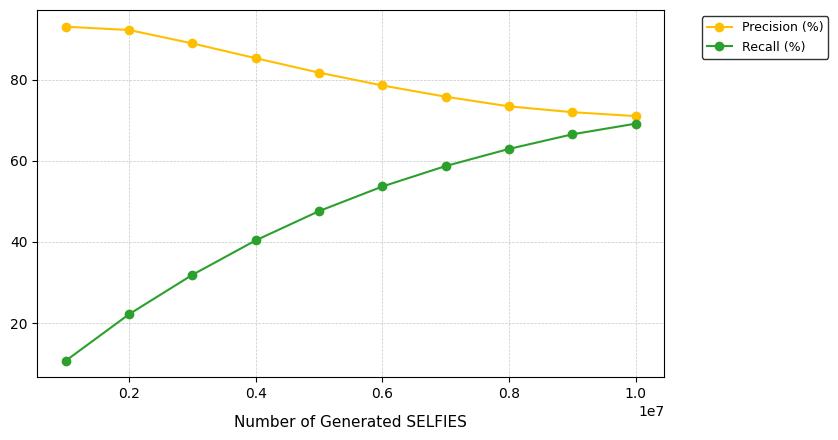

In [75]:
save = '/home/knarik/GDB_Generation_project/Molecular_Generation_with_GDB13/plots/beam_1M_10M_v2.pdf'
beam_size = [1_000_000,2_000_000,3_000_000,4_000_000,5_000_000,6_000_000,7_000_000, 8_000_000, 9_000_000, 10_000_000]
precision = [93.08, 92.26, 88.95, 85.31, 81.75, 78.58, 75.81, 73.43, 72.00, 71.03]
recall =    [10.71, 22.18, 31.90, 40.39, 47.61, 53.67, 58.72, 62.94, 66.54, 69.17]

plt.figure(figsize=(8.5, 4.5))

# Add labels and title
plt.xlabel('Number of Generated SELFIES', fontsize=11, labelpad=10)

# Customize grid and background
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.gca().set_facecolor('white')

# Plot actual data points
plt.plot(beam_size, precision, marker='o', linestyle='-', color='#ffbf00', label='Precision (%)')
plt.plot(beam_size, recall, marker='o', linestyle='-', color='#2ca02c', label='Recall (%)')
# Position the legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=9, edgecolor='black')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 1])

plt.savefig(save, format='pdf')
# Show the plot
plt.show()

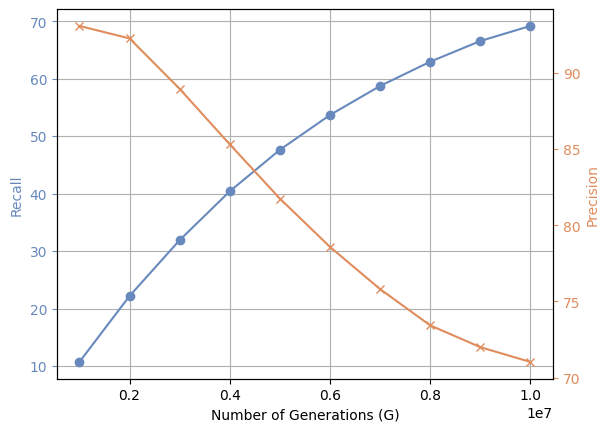

In [44]:

# Data
save_path = '/home/knarik/GDB_Generation_project/Molecular_Generation_with_GDB13/plots/beam_1M_10M_v2.pdf'
beam_size = [1_000_000,2_000_000,3_000_000,4_000_000,5_000_000,6_000_000,7_000_000, 8_000_000, 9_000_000, 10_000_000]
precision = [93.08, 92.26, 88.95, 85.31, 81.75, 78.58, 75.81, 73.43, 72.00, 71.03]
recall =    [10.71, 22.18, 31.90, 40.39, 47.61, 53.67, 58.72, 62.94, 66.54, 69.17]

# Create the figure and axis
fig, ax1 = plt.subplots()

# Plot recall on the left y-axis
ax1.plot(beam_size, recall, '#6889bd', marker='o', label='Recall')
ax1.set_xlabel('Number of Generations (G)')
ax1.set_ylabel('Recall', color='#6889bd')
ax1.tick_params('y', colors='#6889bd')

# Create a second y-axis for precision
ax2 = ax1.twinx()
ax2.plot(beam_size, precision, '#e08c5c', marker='x', label='Precision')
ax2.set_ylabel('Precision', color='#e08c5c')
ax2.tick_params('y', colors='#e08c5c')

# Add a title and grid
# plt.title('Recall and Precision with Beam search.')
ax1.grid(True)

plt.savefig(save_path, format='pdf')
# Show the plot
plt.show()

## Prediction Scatters

In [54]:
def collect_general_statistics(gen_len, str_type):
    subset_names = ['aspirin', 'sas', 'druglike', 'eqdist']
    train = ['canon', 'rand']
    subset_length = [8284280]*4 + [6645440]*4 + [9331077]*4 + [8051185]*4

    df = pd.DataFrame([])

    for subset in subset_names:
        for pretrain in train:
            for finetune in train:
                data = pd.read_excel(f'/nfs/c9/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/predicted_generation_statistics/{str_type}/{subset}/PRETRAIN_{pretrain}_FINETUNE_{finetune}_GEN_LEN_{gen_len}_VALID_LEN_10000_TEMP_1.xlsx')
                df = pd.concat([df, data])
    df['Subset Length'] = subset_length
    df['Recall'] = (df['Actual Unique TP']/df['Subset Length'])*100
    df['Pred Recall'] = (df['Predicted Unique TP']/df['Subset Length'])*100
    return df

In [55]:
gen_1M = collect_general_statistics(gen_len='1M', str_type='selfies')
gen_1M['Generation Length'] = ['1M']*16
gen_1M

,Subset,Actual Duplicated TP,Predicted Duplicated TP,Diff Duplicated TP,Actual Unique TP,Predicted Unique TP,Diff Unique TP,Validation Length,Sum Probs,Subset Length,Recall,Pred Recall,Generation Length
0,aspirin,756477,739939,16538,713478,698421,15057,10000,0.000893,8284280,8.612432,8.430678,1M
0,aspirin,706235,701721,4514,670684,666497,4187,10000,0.000847,8284280,8.095863,8.045322,1M
0,aspirin,762199,745588,16611,717396,702275,15121,10000,0.000900,8284280,8.659727,8.477200,1M
0,aspirin,751584,748248,3336,712999,709660,3339,10000,0.000903,8284280,8.606650,8.566345,1M
0,sas,805514,799113,6401,747632,741846,5786,10000,0.001202,6645440,11.250301,11.163234,1M
0,sas,732804,733826,1022,686069,686801,732,10000,0.001104,6645440,10.323906,10.334921,1M
0,sas,802788,797775,5013,744248,739439,4809,10000,0.001200,6645440,11.199379,11.127013,1M
0,sas,761359,763827,2468,711659,714231,2572,10000,0.001149,6645440,10.708982,10.747686,1M
0,druglike,683074,665395,17679,648842,632650,16192,10000,0.000713,9331077,6.953560,6.780032,1M
0,druglike,616461,609477,6984,590468,583964,6504,10000,0.000653,9331077,6.327973,6.258270,1M


In [56]:
gen_10M = collect_general_statistics(gen_len='10M', str_type='selfies')
gen_10M['Generation Length'] = ['10M']*16
gen_10M

,Subset,Actual Duplicated TP,Predicted Duplicated TP,Diff Duplicated TP,Actual Unique TP,Predicted Unique TP,Diff Unique TP,Validation Length,Sum Probs,Subset Length,Recall,Pred Recall,Generation Length
0,aspirin,7569055,7399390,169665,4558240,4486343,71897,10000,0.000893,8284280,55.022766,54.154893,10M
0,aspirin,7059369,7017213,42156,4452203,4433416,18787,10000,0.000847,8284280,53.742788,53.516009,10M
0,aspirin,7616563,7455878,160685,4540085,4468146,71939,10000,0.000900,8284280,54.803616,53.935236,10M
0,aspirin,7515469,7482479,32990,4672525,4659205,13320,10000,0.000903,8284280,56.402307,56.241520,10M
0,sas,8058081,7991131,66950,4303269,4279902,23367,10000,0.001202,6645440,64.755216,64.403591,10M
0,sas,7326080,7338257,12177,4134374,4143258,8884,10000,0.001104,6645440,62.213698,62.347384,10M
0,sas,8026134,7977750,48384,4265002,4245006,19996,10000,0.001200,6645440,64.179377,63.878479,10M
0,sas,7617117,7638271,21154,4258098,4269162,11064,10000,0.001149,6645440,64.075486,64.241976,10M
0,druglike,6827435,6653951,173484,4369476,4293835,75641,10000,0.000713,9331077,46.827135,46.016499,10M
0,druglike,6163090,6094771,68319,4189576,4152256,37320,10000,0.000653,9331077,44.899169,44.499215,10M


In [57]:
df = pd.concat([gen_10M, gen_1M]) 

# List of columns to keep
columns_to_keep = ['Subset', 'Recall', 'Pred Recall', 'Generation Length']

# Select the specified columns
df = df.loc[:, columns_to_keep]
df

,Subset,Recall,Pred Recall,Generation Length
0,aspirin,55.022766,54.154893,10M
0,aspirin,53.742788,53.516009,10M
0,aspirin,54.803616,53.935236,10M
0,aspirin,56.402307,56.241520,10M
0,sas,64.755216,64.403591,10M
0,sas,62.213698,62.347384,10M
0,sas,64.179377,63.878479,10M
0,sas,64.075486,64.241976,10M
0,druglike,46.827135,46.016499,10M
0,druglike,44.899169,44.499215,10M


In [58]:
df.loc[len(df)] = {"Subset": "code", "Recall": 10.7, "Pred Recall": 11.68, "Generation Length": "100K"}
df.loc[len(df)] = {"Subset": "code", "Recall": 58.23, "Pred Recall": 60.12, "Generation Length": "1M"}


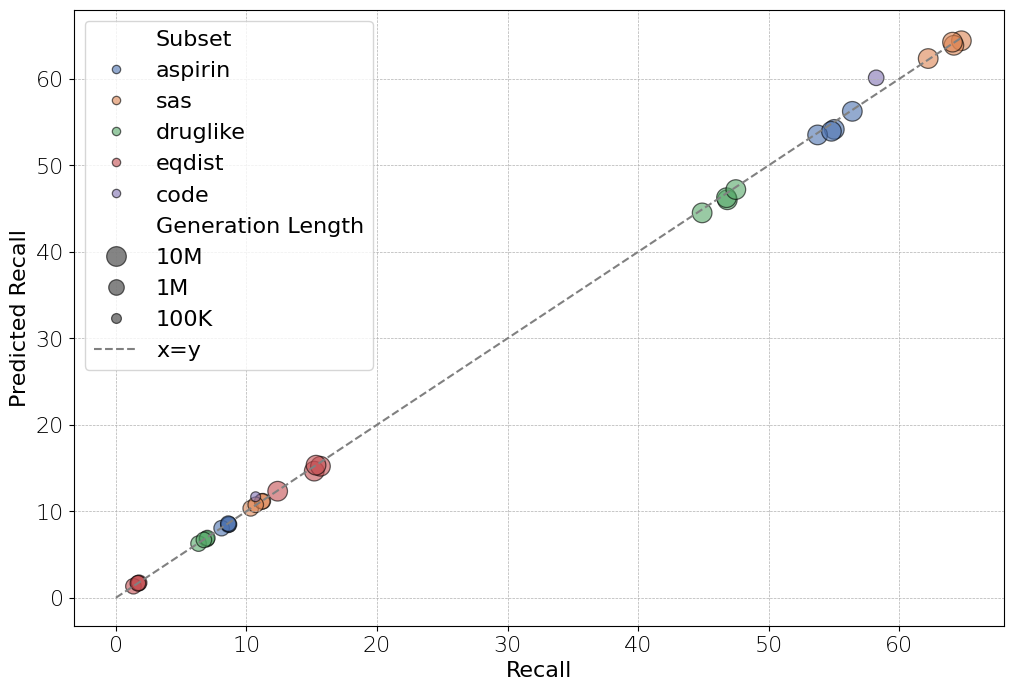

In [59]:
# Assuming df is your DataFrame
plt.figure(figsize=(12, 8))

# Create the scatter plot
sns.scatterplot(data=df, x='Recall', y='Pred Recall', hue='Subset', size='Generation Length', sizes=(50, 200), palette='deep', alpha=0.6, edgecolor='black')

# Add the x=y line
plt.plot([0, max(df['Recall'].max(), df['Pred Recall'].max())], [0, max(df['Recall'].max(), df['Pred Recall'].max())], linestyle='--', color='grey', label='x=y')

# Add labels and title
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Predicted Recall', fontsize=16)
# plt.title('Recall vs Predicted Recall', fontsize=16)

# Customize ticks
plt.xticks(fontsize=16, fontweight='light')
plt.yticks(fontsize=16, fontweight='light')

# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show legend
plt.legend(fontsize=16)

plt.savefig('recall_pred_recall_all.pdf')
# Show the plot
plt.show()


In [ ]:
def collect_general_statistics(gen_len, str_type):
    subset_names = ['aspirin', 'sas', 'druglike', 'eqdist']
    train = ['canon', 'rand']
    subset_length = [8284280]*4 + [6645440]*4 + [9331077]*4 + [8051185]*4

    df = pd.DataFrame([])

    for subset in subset_names:
        for pretrain in train:
            for finetune in train:
                data = pd.read_excel(f'/nfs/c9/mnt/2tb/chem/hasmik/GDB_Generation_hf_project/Molecular_Generation_with_GDB13/src/statistics/predicted_generation_statistics/{str_type}/{subset}/PRETRAIN_{pretrain}_FINETUNE_{finetune}_GEN_LEN_{gen_len}_VALID_LEN_10000_TEMP_1.xlsx')
                df = pd.concat([df, data])
    df['Subset Length'] = subset_length
    df['Recall'] = (df['Actual Unique TP']/df['Subset Length'])*100
    df['Pred Recall'] = (df['Predicted Unique TP']/df['Subset Length'])*100
    return df



gen_1M = collect_general_statistics(gen_len='1M')
gen_1M['Generation Length'] = ['1M']*16
gen_1M

gen_100K = collect_general_statistics(gen_len='100K')
gen_100K['Generation Length'] = ['1K']*16
gen_100K

In [ ]:
# For code data
df = pd.concat([gen_1M, gen_100K]) 

# List of columns to keep
columns_to_keep = ['Subset', 'Recall', 'Pred Recall', 'Generation Length']

# Select the specified columns
df = df.loc[:, columns_to_keep]
df

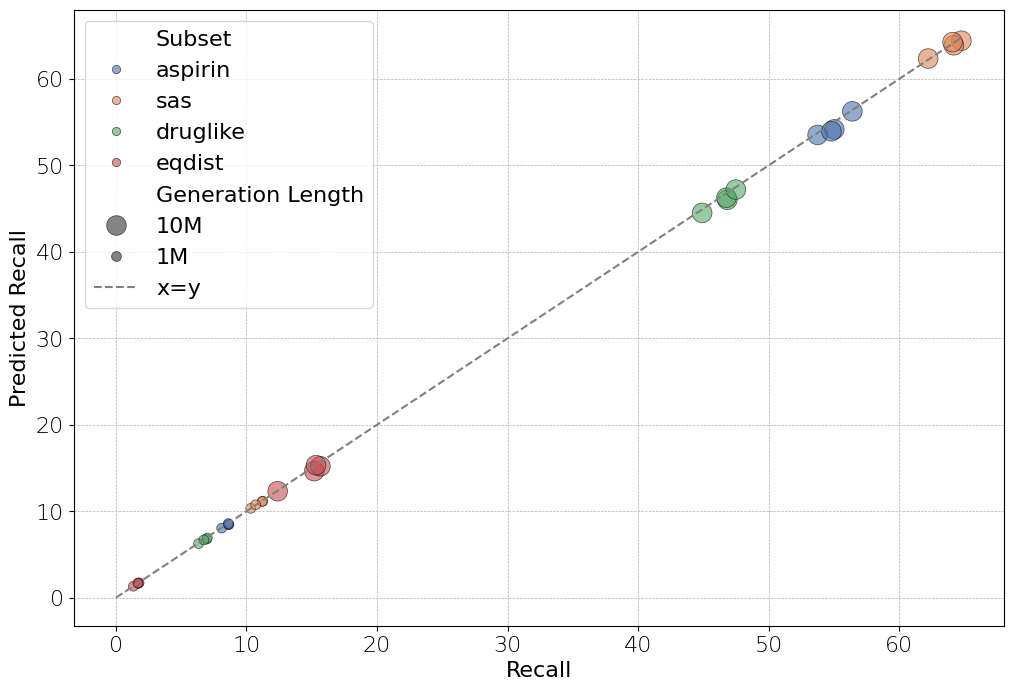

In [ ]:
# Assuming df is your DataFrame
plt.figure(figsize=(12, 8))

# Create the scatter plot
sns.scatterplot(data=df, x='Recall', y='Pred Recall', hue='Subset', size='Generation Length', sizes=(50, 200), palette='deep', alpha=0.6, edgecolor='black')

# Add the x=y line
plt.plot([0, max(df['Recall'].max(), df['Pred Recall'].max())], [0, max(df['Recall'].max(), df['Pred Recall'].max())], linestyle='--', color='grey', label='x=y')

# Add labels and title
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Predicted Recall', fontsize=16)
# plt.title('Recall vs Predicted Recall', fontsize=16)

# Customize ticks
plt.xticks(fontsize=16, fontweight='light')
plt.yticks(fontsize=16, fontweight='light')

# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show legend
plt.legend(fontsize=16)

plt.savefig('recall_pred_recall_code.pdf')
# Show the plot
plt.show()


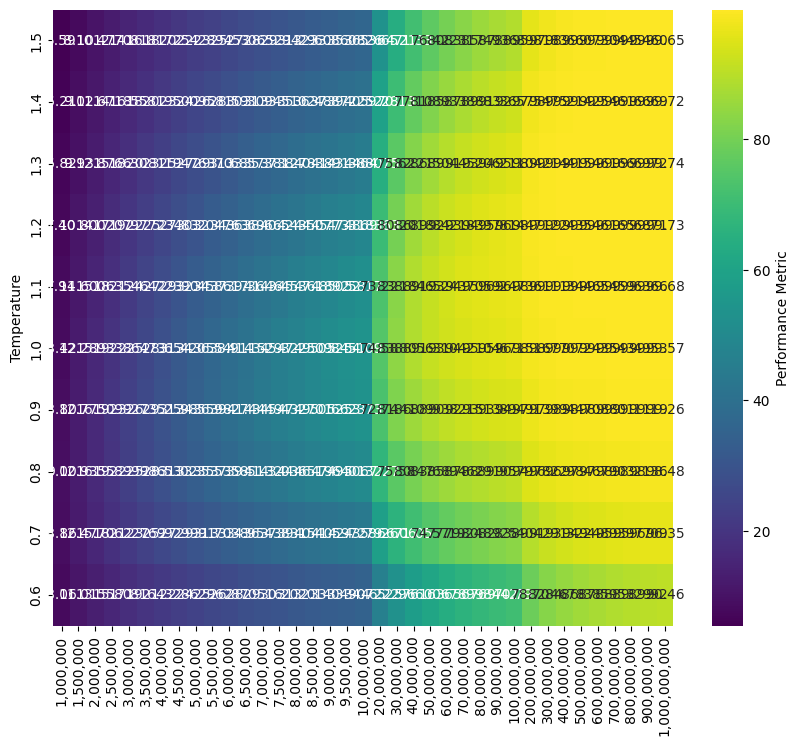

In [70]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from your table (example for the first few rows)
data = {
    "Temperature": [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5],
    "1,000,000": [8.06, 8.86, 9.00, 8.8, 8.42, 7.94, 7.40, 6.82, 6.21, 5.59],
    "1,500,000": [11.01, 12.47, 12.93, 12.77, 12.28, 11.60, 10.80, 9.93, 9.02, 8.10],
    "2,000,000": [13.55, 15.70, 16.55, 16.5, 15.93, 15.06, 14.02, 12.87, 11.67, 10.47],
    "2,500,000": [15.80, 18.62, 19.89, 19.99, 19.38, 18.35, 17.07, 15.66, 14.18, 12.70],
    "3,000,000": [17.81, 21.27, 22.99, 23.27, 22.64, 21.46, 19.97, 18.30, 16.55, 14.81],
    "3,500,000": [19.64, 23.69, 25.86, 26.35, 25.73, 24.42, 22.72, 20.81, 18.81, 16.81],
    "4,000,000": [21.32, 25.92, 28.53, 29.25, 28.65, 27.23, 25.34, 23.19, 20.95, 18.72],
    "4,500,000": [22.86, 27.99, 31.02, 31.98, 31.42, 29.90, 27.83, 25.47, 23.00, 20.54],
    "5,000,000": [24.29, 29.91, 33.35, 34.55, 34.05, 32.45, 30.20, 27.63, 24.95, 22.28],
    "5,500,000": [25.62, 31.70, 35.53, 36.98, 36.54, 34.86, 32.47, 29.70, 26.81, 23.94],
    "6,000,000": [26.87, 33.38, 37.58, 39.27, 38.91, 37.17, 34.63, 31.68, 28.59, 25.53],
    "6,500,000": [28.05, 34.95, 39.51, 41.44, 41.15, 39.36, 36.69, 33.57, 30.30, 27.06],
    "7,000,000": [29.16, 36.43, 41.32, 43.49, 43.29, 41.46, 38.66, 35.38, 31.94, 28.52],
    "7,500,000": [30.20, 37.83, 43.03, 45.43, 45.32, 43.45, 40.54, 37.12, 33.51, 29.94],
    "8,000,000": [31.20, 39.15, 44.65, 47.27, 47.25, 45.36, 42.35, 38.78, 35.02, 31.29],
    "8,500,000": [32.14, 40.40, 46.19, 49.01, 49.09, 47.18, 44.07, 40.38, 36.48, 32.60],
    "9,000,000": [33.04, 41.59, 47.64, 50.66, 50.84, 48.92, 45.73, 41.91, 37.87, 33.86],
    "9,500,000": [33.90, 42.72, 49.01, 52.23, 52.51, 50.58, 47.31, 43.38, 39.22, 35.08],
    "10,000,000": [34.72, 43.79, 50.32, 53.73, 54.09, 52.17, 48.83, 44.80, 40.52, 36.26],
    "20,000,000": [46.22, 58.26, 67.27, 72.74, 74.58, 73.22, 69.63, 64.75, 59.28, 53.65],
    "30,000,000": [52.96, 66.06, 75.58, 81.41, 83.80, 83.18, 80.20, 75.62, 70.13, 64.21],
    "40,000,000": [57.60, 71.05, 80.47, 86.09, 88.56, 88.46, 86.18, 82.21, 77.10, 71.33],
    "50,000,000": [61.06, 74.57, 83.68, 88.93, 91.31, 91.52, 89.84, 86.50, 81.89, 76.42],
    "60,000,000": [63.78, 77.19, 85.94, 90.82, 93.04, 93.43, 92.21, 89.44, 85.33, 80.23],
    "70,000,000": [65.99, 79.24, 87.62, 92.15, 94.21, 94.70, 93.83, 91.52, 87.88, 83.17],
    "80,000,000": [67.84, 80.89, 88.91, 93.13, 95.04, 95.59, 94.97, 93.06, 89.83, 85.49],
    "90,000,000": [69.42, 82.25, 89.95, 93.89, 95.67, 96.24, 95.81, 94.21, 91.36, 87.36],
    "100,000,000": [70.79, 83.40, 90.79, 94.49, 96.15, 96.73, 96.44, 95.10, 92.57, 88.89],
    "200,000,000": [78.70, 89.42, 94.78, 97.13, 98.16, 98.61, 98.71, 98.42, 97.54, 95.81],
    "300,000,000": [82.46, 91.91, 96.22, 97.99, 98.77, 99.11, 99.22, 99.14, 98.75, 97.83],
    "400,000,000": [84.78, 93.32, 96.98, 98.44, 99.07, 99.34, 99.43, 99.41, 99.21, 98.66],
    "500,000,000": [86.38, 94.24, 97.46, 98.7, 99.24, 99.46, 99.54, 99.54, 99.42, 99.07],
    "600,000,000": [87.59, 94.89, 97.79, 98.88, 99.35, 99.54, 99.61, 99.61, 99.54, 99.30],
    "700,000,000": [88.53, 95.39, 98.03, 99.01, 99.43, 99.59, 99.65, 99.66, 99.61, 99.44],
    "800,000,000": [89.29, 95.77, 98.21, 99.11, 99.49, 99.63, 99.68, 99.69, 99.66, 99.54],
    "900,000,000": [89.92, 96.09, 98.36, 99.19, 99.53, 99.66, 99.71, 99.72, 99.69, 99.60],
    "1,000,000,000": [90.46, 96.35, 98.48, 99.26, 99.57, 99.68, 99.73, 99.74, 99.72, 99.65],
}

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import LogLocator

# Convert to DataFrame
df = pd.DataFrame(data).set_index("Temperature")

# Transpose the DataFrame to swap axes
df = df[::-1]  # Now Temperature is on X-axis, and Generation Count is on Y-axis

# Plot heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df, annot=True, fmt=".2f", cmap="viridis", cbar_kws={"label": "Performance Metric"})

# Set log scale for y-axis
# ax.set_yticks(range(len(df.index)))  # Set ticks at index positions
# ax.set_yticklabels(df.index)  # Use original column names as labels
# plt.yscale("log")  # Apply log scale

# # Adjust y-axis ticks for log scale readability
# # ax.yaxis.set_major_locator(LogLocator(base=10.0, subs="auto", numticks=10))

# # Labels and title
# plt.xlabel("Temperature")
# plt.ylabel("Generation Count (log scale)")
# plt.title("Performance Metric vs. Temperature and Generation Count")

# plt.show()

In [138]:
# Convert to DataFrame
df = pd.DataFrame(data)

# Extract max value from each row
df["Max Value"] = df.max(axis=1)

# Plot heatmap with Temperature on X-axis, Generation Count on Y-axis, and Max Value as color
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df[["Max Value"]], annot=True, fmt=".2f", cmap="viridis", cbar_kws={"label": "Max Performance Metric"})

# Labels
plt.xlabel("Temperature")
plt.ylabel("Generation Count (Log Scale)")
plt.title("Maximum Performance Metric per Generation Count")

# Set log scale for y-axis
plt.yscale("log")

plt.show()

ValueError: math domain error

<Figure size 1000x800 with 2 Axes>

In [139]:
df = pd.DataFrame(data)

In [140]:
custom_index = ["Gen1", "Gen2", "Gen3", "Gen4", "Gen5"]

,Temperature,"1,000,000","1,500,000","2,000,000","2,500,000","3,000,000","3,500,000","4,000,000","4,500,000","5,000,000",...,"100,000,000","200,000,000","300,000,000","400,000,000","500,000,000","600,000,000","700,000,000","800,000,000","900,000,000","1,000,000,000"
0,0.6,8.06,11.01,13.55,15.80,17.81,19.64,21.32,22.86,24.29,...,70.79,78.70,82.46,84.78,86.38,87.59,88.53,89.29,89.92,90.46
1,0.7,8.86,12.47,15.70,18.62,21.27,23.69,25.92,27.99,29.91,...,83.40,89.42,91.91,93.32,94.24,94.89,95.39,95.77,96.09,96.35
2,0.8,9.00,12.93,16.55,19.89,22.99,25.86,28.53,31.02,33.35,...,90.79,94.78,96.22,96.98,97.46,97.79,98.03,98.21,98.36,98.48
3,0.9,8.80,12.77,16.50,19.99,23.27,26.35,29.25,31.98,34.55,...,94.49,97.13,97.99,98.44,98.70,98.88,99.01,99.11,99.19,99.26
4,1.0,8.42,12.28,15.93,19.38,22.64,25.73,28.65,31.42,34.05,...,96.15,98.16,98.77,99.07,99.24,99.35,99.43,99.49,99.53,99.57
5,1.1,7.94,11.60,15.06,18.35,21.46,24.42,27.23,29.90,32.45,...,96.73,98.61,99.11,99.34,99.46,99.54,99.59,99.63,99.66,99.68
6,1.2,7.40,10.80,14.02,17.07,19.97,22.72,25.34,27.83,30.20,...,96.44,98.71,99.22,99.43,99.54,99.61,99.65,99.68,99.71,99.73
7,1.3,6.82,9.93,12.87,15.66,18.30,20.81,23.19,25.47,27.63,...,95.10,98.42,99.14,99.41,99.54,99.61,99.66,99.69,99.72,99.74
8,1.4,6.21,9.02,11.67,14.18,16.55,18.81,20.95,23.00,24.95,...,92.57,97.54,98.75,99.21,99.42,99.54,99.61,99.66,99.69,99.72
9,1.5,5.59,8.10,10.47,12.70,14.81,16.81,18.72,20.54,22.28,...,88.89,95.81,97.83,98.66,99.07,99.30,99.44,99.54,99.60,99.65


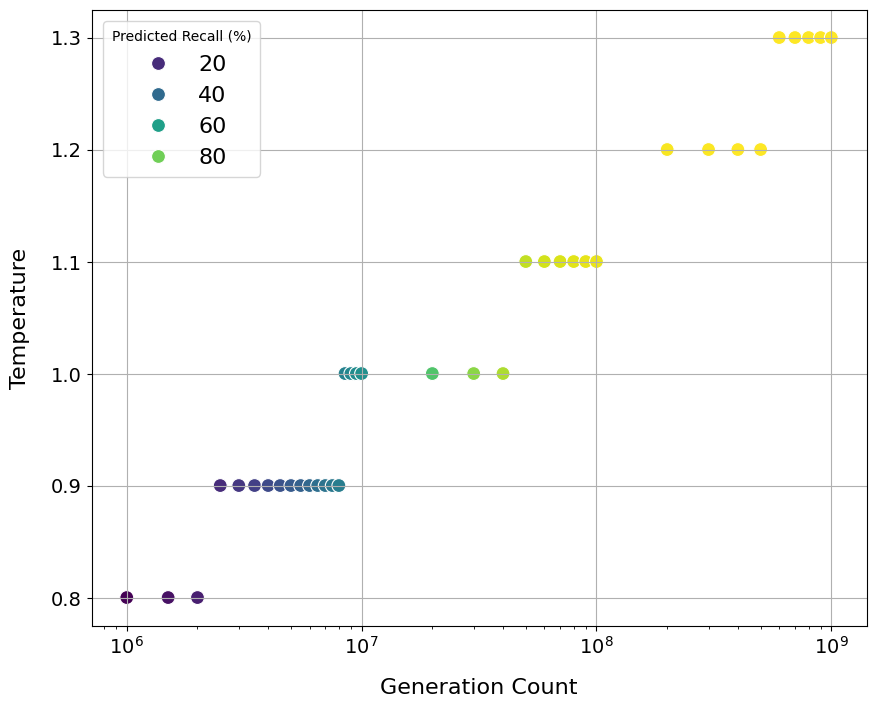

In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data from your table
data = {
    "0.6": [8.06, 11.01, 13.55, 15.80, 17.81, 19.64, 21.32, 22.86, 24.29, 25.62, 26.87, 28.05, 29.16, 30.20, 31.20, 32.14, 33.04, 33.90, 34.72, 46.22, 52.96, 57.60, 61.06, 63.78, 65.99, 67.84, 69.42, 70.79, 78.70, 82.46, 84.78, 86.38, 87.59, 88.53, 89.29, 89.92, 90.46],
    "0.7": [8.86, 12.47, 15.70, 18.62, 21.27, 23.69, 25.92, 27.99, 29.91, 31.70, 33.38, 34.95, 36.43, 37.83, 39.15, 40.40, 41.59, 42.72, 43.79, 58.26, 66.06, 71.05, 74.57, 77.19, 79.24, 80.89, 82.25, 83.40, 89.42, 91.91, 93.32, 94.24, 94.89, 95.39, 95.77, 96.09, 96.35],
    "0.8": [9.00, 12.93, 16.55, 19.89, 22.99, 25.86, 28.53, 31.02, 33.35, 35.53, 37.58, 39.51, 41.32, 43.03, 44.65, 46.19, 47.64, 49.01, 50.32, 67.27, 75.58, 80.47, 83.68, 85.94, 87.62, 88.91, 89.95, 90.79, 94.78, 96.22, 96.98, 97.46, 97.79, 98.03, 98.21, 98.36, 98.48],
    "0.9": [8.8, 12.77, 16.5, 19.99, 23.27, 26.35, 29.25, 31.98, 34.55, 36.98, 39.27, 41.44, 43.49, 45.43, 47.27, 49.01, 50.66, 52.23, 53.73, 72.74, 81.41, 86.09, 88.93, 90.82, 92.15, 93.13, 93.89, 94.49, 97.13, 97.99, 98.44, 98.7, 98.88, 99.01, 99.11, 99.19, 99.26],
    "1.0": [8.42, 12.28, 15.93, 19.38, 22.64, 25.73, 28.65, 31.42, 34.05, 36.54, 38.91, 41.15, 43.29, 45.32, 47.25, 49.09, 50.84, 52.51, 54.09, 74.58, 83.80, 88.56, 91.31, 93.04, 94.21, 95.04, 95.67, 96.15, 98.16, 98.77, 99.07, 99.24, 99.35, 99.43, 99.49, 99.53, 99.57],
    "1.1": [7.94, 11.60, 15.06, 18.35, 21.46, 24.42, 27.23, 29.90, 32.45, 34.86, 37.17, 39.36, 41.46, 43.45, 45.36, 47.18, 48.92, 50.58, 52.17, 73.22, 83.18, 88.46, 91.52, 93.43, 94.70, 95.59, 96.24, 96.73, 98.61, 99.11, 99.34, 99.46, 99.54, 99.59, 99.63, 99.66, 99.68],
    "1.2": [7.40, 10.80, 14.02, 17.07, 19.97, 22.72, 25.34, 27.83, 30.20, 32.47, 34.63, 36.69, 38.66, 40.54, 42.35, 44.07, 45.73, 47.31, 48.83, 69.63, 80.20, 86.18, 89.84, 92.21, 93.83, 94.97, 95.81, 96.44, 98.71, 99.22, 99.43, 99.54, 99.61, 99.65, 99.68, 99.71, 99.73],
    "1.3": [6.82, 9.93, 12.87, 15.66, 18.30, 20.81, 23.19, 25.47, 27.63, 29.70, 31.68, 33.57, 35.38, 37.12, 38.78, 40.38, 41.91, 43.38, 44.80, 64.75, 75.62, 82.21, 86.50, 89.44, 91.52, 93.06, 94.21, 95.10, 98.42, 99.14, 99.41, 99.54, 99.61, 99.66, 99.69, 99.72, 99.74],
    "1.4": [6.21, 9.02, 11.67, 14.18, 16.55, 18.81, 20.95, 23.00, 24.95, 26.81, 28.59, 30.30, 31.94, 33.51, 35.02, 36.48, 37.87, 39.22, 40.52, 59.28, 70.13, 77.10, 81.89, 85.33, 87.88, 89.83, 91.36, 92.57, 97.54, 98.75, 99.21, 99.42, 99.54, 99.61, 99.66, 99.69, 99.72],
    "1.5": [5.59, 8.10, 10.47, 12.70, 14.81, 16.81, 18.72, 20.54, 22.28, 23.94, 25.53, 27.06, 28.52, 29.94, 31.29, 32.60, 33.86, 35.08, 36.26, 53.65, 64.21, 71.33, 76.42, 80.23, 83.17, 85.49, 87.36, 88.89, 95.81, 97.83, 98.66, 99.07, 99.30, 99.44, 99.54, 99.60, 99.65],
}

# Convert to DataFrame
df = pd.DataFrame(data, index=[1000000, 1500000, 2000000, 2500000, 3000000, 3500000, 4000000, 4500000, 5000000, 5500000, 6000000, 6500000, 7000000, 7500000, 8000000, 8500000, 9000000, 9500000, 10000000, 20000000, 30000000, 40000000, 50000000, 60000000, 70000000, 80000000, 90000000, 100000000, 200000000, 300000000, 400000000, 500000000, 600000000, 700000000, 800000000, 900000000, 1000000000])

# Extract the maximum value from each row
df['Max Value'] = df.max(axis=1)

# Print the max values
# print(df['Max Value'])

# Plot the data
plt.figure(figsize=(10, 8))
sns.scatterplot(x=df.index, y=l, hue=df['Max Value'], palette='viridis', s=100)
# sns.heatmap(df['Max Value'].view(:), annot=True, fmt=".2f", cmap="viridis", cbar_kws={"label": "Performance Metric"})



# plt.xticks(fontsize=14, fontweight='light')
# plt.yticks(fontsize=14, fontweight='light')
plt.xscale('log')  # Use log scale for x-axis due to large range of generation counts
plt.xlabel('Generation Count')
plt.ylabel('Temperature')
# plt.title('Max Value vs. Generation Count')
plt.legend(title="Predicted Recall (%)", fontsize=16)
plt.grid(True)

ax = plt.gca()
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.xlabel('Generation Count', fontsize=16, labelpad=15)  # labelpad adds space between label and axis
plt.ylabel('Temperature', fontsize=16, labelpad=15)

plt.savefig('recall_pred_temp.pdf')
plt.show()

In [153]:
l = [0.8]*3 + [0.9]*12 + [1]*7 + [1.1]*6 + [1.2]*4 + [1.3]*5

In [151]:
len(df.index)

37